##### Esc + shift + L (add num lines)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, tan,pi,e
import pandas as pd
from cmath import asin
from cmath import sqrt,  exp

im = complex(0, 1)

In [6]:
from itertools import product

#### R calculation:

In [7]:
def transfer_matrix(N1, N2):
    tm = np.empty((2,2), dtype = np.complex)
    tm[0, 0] = (N2 + N1) / (2. * N2)
    tm[0, 1] = (N2 - N1) / (2. * N2)
    tm[1, 0] = (N2 - N1) / (2. * N2)
    tm[1, 1] = (N2 + N1) / (2. * N2)
    return tm

def N_calculation(n_first_media, incident_angle, n_current_media):
    return (n_current_media ** 2 - n_first_media ** 2 * (sin(incident_angle)) ** 2) ** 0.5

def phase_shift(d, N, k0):
    p_shift = np.empty((2, 2), dtype = np.complex)
    p_shift[0, 0] = exp(1.j * d * N * k0)
    p_shift[0, 1] = 0.+0.j
    p_shift[1, 0] = 0.+0.j
    p_shift[1, 1] = exp(-1.j * d * N * k0)
    return p_shift

def R_func(dictionary_structure={}, wl = 780, teta = 45):
    list_N = []

    T = np.eye(2, dtype=np.complex)
    tet = teta * np.pi / 180
    k0 = 2 * np.pi / wl
    n0 = complex(0., 0.)  # current n
    for i in range(0, len(dictionary_structure)):
        
        if i == 0:
            n0 = dictionary_structure[i]['n']
            list_N.append(N_calculation(n0, tet, n0))
            continue
            
        if dictionary_structure[i]['name'] == 'ФК':
            n1 = dictionary_structure[i]['n1']
            n2 = dictionary_structure[i]['n2']
            d1 = dictionary_structure[i]['d1']
            d2 = dictionary_structure[i]['d2']
            num_layers = int(dictionary_structure[i]['N'])
            N1 = N_calculation(n0, tet, n1)
            N2 = N_calculation(n0, tet, n2)
            from_upper_to_1 = transfer_matrix(list_N[-1], N1)
            from_1_to_2 = transfer_matrix(N1, N2)
            from_2_to_1 = transfer_matrix(N2, N1)
            F_n1 = phase_shift(d1, N1, k0)  # x1 - d, x2 - N, x3 - k0
            F_n2 = phase_shift(d2, N2, k0)          

            T = F_n2 @ from_1_to_2 @ F_n1 @ from_upper_to_1 @ T
            T_bilayer = F_n2 @from_1_to_2 @ F_n1 @from_2_to_1
            T = np.linalg.matrix_power(T_bilayer, num_layers - 1) @ T
            list_N.append(N1)
            list_N.append(N2)

        elif dictionary_structure[i]['name'] == 'Слой':
            n = dictionary_structure[i]['n']
            d = dictionary_structure[i]['d']
            N = N_calculation(n0, tet, n)
            from_this_to_next = transfer_matrix(list_N[-1], N)
            F = phase_shift(d, N, k0)
            T = np.dot(from_this_to_next, T)
            T = np.dot(F, T)
            list_N.append(N)
            
        elif dictionary_structure[i]['name'] == 'Среда':
            n = dictionary_structure[i]['n']
            N = N_calculation(n0, tet, n)
            from_last_to_sub = transfer_matrix(list_N[-1], N)
            T = np.dot(from_last_to_sub, T)
            list_N.append(N)

    return (-(T[1, 0] / T[1, 1]))

In [345]:
wl = 780.
"""didic = {
    0: {
        'name': 'Среда',
        'n': 1.5 + 0.j
    }, 
    1: {
        'name': 'ФК',
        'n1': 2.07+0.00001j,
        'd1': 143.,
        'n2': 1.45 + 0.00002j,
        'd2': 204.,
        'N' : 10
    },
    2: {
        'name': 'Среда',
        'n': 1. + 0.j
    }
}"""
didic = {
    0: {
        'name': 'Среда',
        'n': 1.5 + 0.j
    },
    1: {
        'name': 'Слой',
        'n': 1 + 0.j,
        'd': 500
    },  
    2: {
        'name': 'ФК',
        'n1': 1.45 + 0.00002j,
        'd1': 204.,
        'n2': 2.07+0.00002j,
        'd2': 143.,
        'N' : 10
    },
    3: {
        'name': 'Среда',
        'n': 1.52 + 0.j
    }
}

Text(0, 0.5, '|R|')

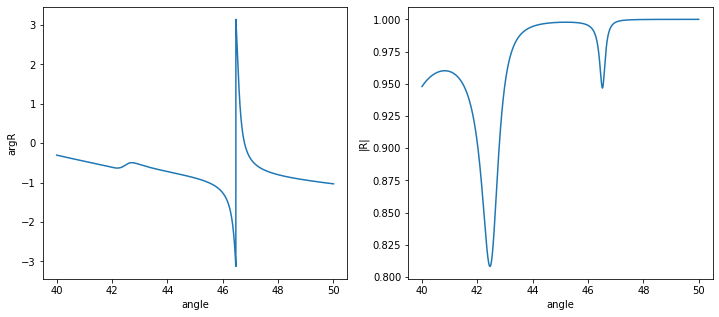

In [346]:
def decor(angles):
    wl = 780.
    return R_func(didic, wl, angles)
vectorize_R = np.vectorize(decor)

''' test vectorize R: '''
fig, ax1 = plt.subplots(1, 2, figsize=(12, 5))
angles = np.linspace(40, 50, 10000)
res = vectorize_R(angles)
ax1[0].plot(angles, np.angle(res))
ax1[0].set_xlabel("angle")
ax1[0].set_ylabel("argR")

ax1[1].plot(angles, abs(res))
ax1[1].set_xlabel("angle")
ax1[1].set_ylabel("|R|")

In [283]:
def spectral(a, k):
    return abs(np.sqrt(a)/(2 * np.sqrt(np.pi)) * np.exp(-a**2 * k**2 / 4))
vectorize_spectral = np.vectorize(spectral)

a - значение координаты, по уровню амлитуды $\frac{1}{e}$ (в микрометрах). Полная ширина = 2a. 
N_x - число гармоник по k_x, которые будем использовать.
Меньшая гармоника будет по амплитуде составлять не больше 1/20.
(50a - ограничимся таким масштабом по х)

Fix: Мощность в перетяжке гауссовога пучка $P \propto w  \sim \Rightarrow S = \frac{\sqrt{a}}{2 \sqrt{\pi}}e^{-{\frac{ak_x}{2}}^2}$

In [11]:
a = 5
N_x = 200

k_min = 2 * np.sqrt(np.log(8)) / a
k = 2 * np.pi * 1000000000 / wl * didic[0]['n'].real
print("k_min = %f"%k_min)
print(k/1000000)

k_min = 0.576811
12.08304866765305


dk: 0.0057681075464
Угол сходимости, град: -2.73617923547


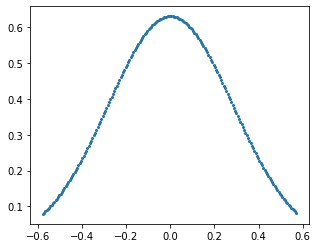

In [12]:
plt.figure(figsize=(5, 4))
dk_x = 2 * k_min / N_x
print("dk: " + str(dk_x))
k_n = np.arange(-N_x // 2, N_x // 2)
k_x = k_n * dk_x
S_k = []

for i in (k_x):
    y = spectral(a, i)
    S_k.append(y)
print("Угол сходимости, град: " + str(np.arcsin(k_x[0] * 1000000 / k).real * 180 / pi))
S_k = np.array(S_k)
plt.plot(k_x, S_k, 'o', markersize=2)

In [13]:
def get_k_x(a=7, N_x=200, decr_times=20):
    k_min = 2 * np.sqrt(np.log(decr_times)) / a
    dk_x = 2 * k_min / N_x
    return np.arange(-N_x // 2, N_x // 2) * dk_x

def S_k(a, k_x):
    return vectorize_spectral(a, k_x)




#### Прямая прогонка: рассчет прямого поля от падающего луча. Обратная прогонка рассчет отраженного луча. 
#### l - расстояние вдоль оси пучка, на которое мы недоюстировались. + - перефокусировка, -  - недофокусировка (желательно целое число микрон)
#### alpha - угол падения центральной спектральной компоненты 

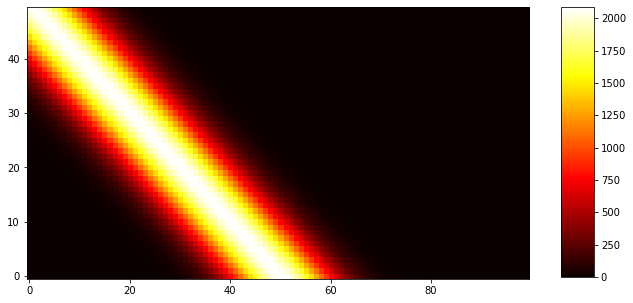

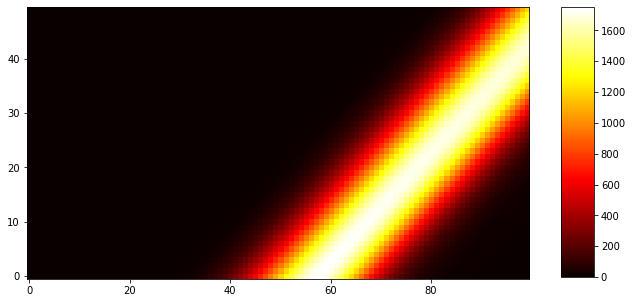

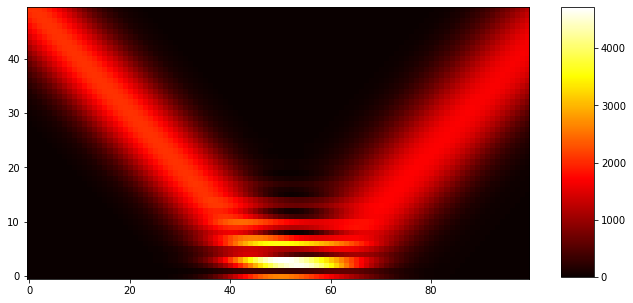

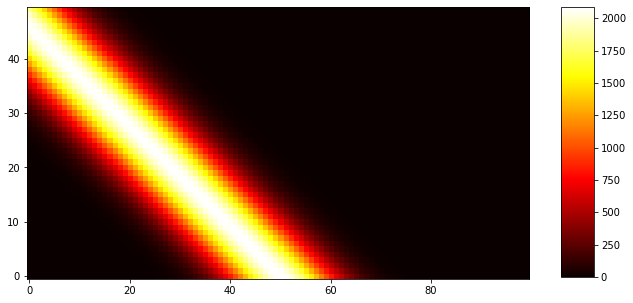

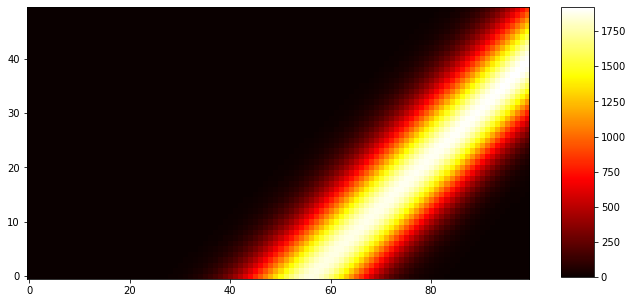

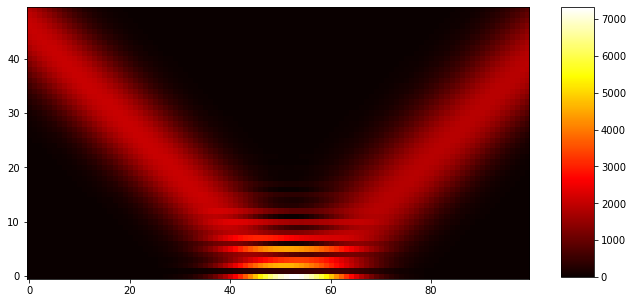

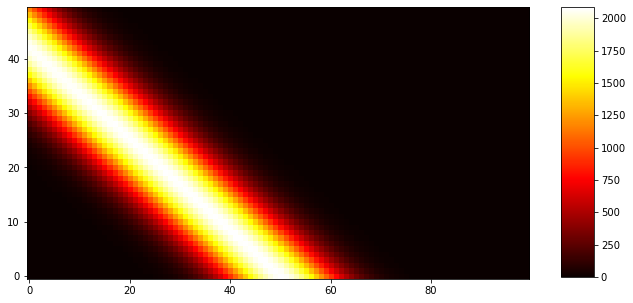

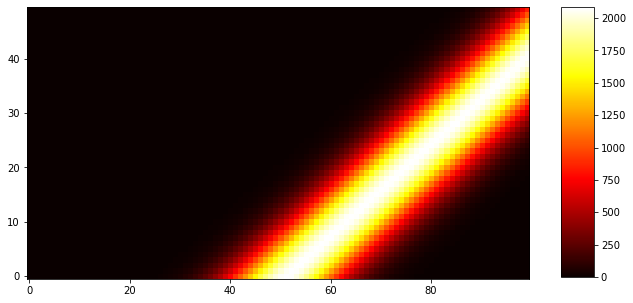

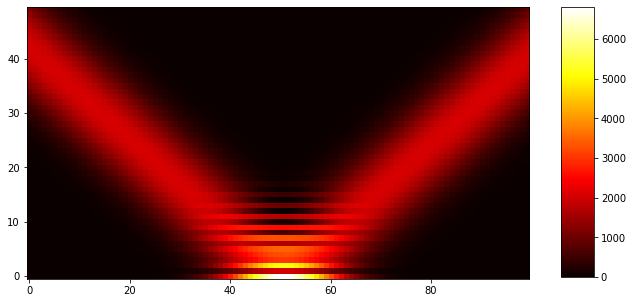

In [120]:
'''
X - x-coordinate in micrometers
Z - z-coordinate in micrometers
E - electroagnetic field
'''
a = np.linspace(45, 50, 3)
E_inp = []
E_out = []
E_res = []
for i in a:
    alpha = i
    l_0 = 0  # расстояние вдоль оси пучка до сфокусированного
    #alpha = 45.9
    h_0 = int(l_0 * cos(alpha * np.pi / 180)) # координата перетяжки над поверхностью слоя
    x_0 = int(l_0 * sin(alpha * np.pi / 180)) # координата смещения перетяжки по х относительно нуля
    x_offset = 50 # отступ луча слева в микронах, который рисуем
    x_c_index = x_offset # положение центрального луча
    if x_0 > x_offset:
        x_offset = x_0 - x_offset
    else:
        x_offset = x_0 - x_offset
    X = np.arange(x_offset, 100 + x_offset, 1)
    Z = np.arange(0, 50, 1)
    E = np.zeros((np.shape(Z)[0], np.shape(X)[0]), dtype=np.complex)

   # X = np.array([X[-200]])

    k_x = get_k_x(5)
    k_mkm = k / 1000000.
    k_z = k_mkm * np.cos(np.arcsin(k_x / k_mkm))
    s = S_k(10, k_x).reshape((-1, 1))
    k_matrix = np.vstack((k_x, k_z))
    angles = 180 / np.pi * np.arcsin(k_x / k_mkm) + alpha
    R = vectorize_R(angles, wl, didic).reshape((-1, 1))

    tmp = np.empty((2, 1))
    tmp1 = np.empty((2, 1))

    rot_matrix = np.empty((2, 2), dtype = np.complex)
    rot_matrix[0, 0] = cos(np.pi * alpha / 180)
    rot_matrix[0, 1] = sin(np.pi * alpha / 180)
    rot_matrix[1, 0] = sin(np.pi * alpha / 180)
    rot_matrix[1, 1] = -cos(np.pi * alpha / 180)

    E_inp.append(E_input())
    E_out.append(E_reflected(s * R))
    E_res.append(E_inp[-1] + E_out[-1])
    plot_2Dmap(E_res[-1])


29
28.2842712475


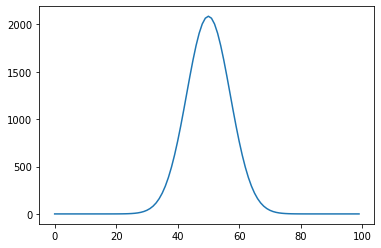

In [123]:
plt.plot(abs(E_inp[0][0])**2)
lol = np.array(abs(E_inp[0][0])**2 > max(abs(E_inp[0][0])**2) / np.e ** 2) & np.array(abs((E_inp[::-1])[0][0])**2 > max(abs(E_inp[0][0])**2)/ np.e ** 2)
print(np.size(lol[lol == True]))
print(20 / np.cos(45 * np.pi / 180))


In [101]:
def I_d(x):
    int1 = []
    for line in E_res:
        int1.append(np.sum((np.abs(np.reshape(line[:, x], (1, -1))))**2))
    return (int1)
x = np.arange(450, 900, 50)

x_0 = 200
x_range = x_0 + np.arange(-25, 26, 1)
y_range = abs(x_0 / np.tan(45))

for i in x:
    plt.plot(I_d(i))


IndexError: index 450 is out of bounds for axis 1 with size 100

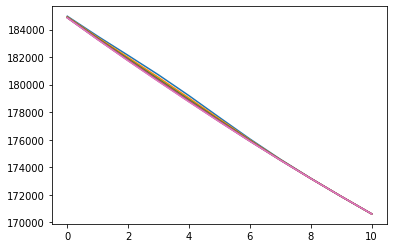

In [160]:
x = np.arange(50, 400, 50)
for i in x:
    plt.plot(I_d(i))

In [93]:
'''
X - x-coordinate in micrometers
Z - z-coordinate in micrometers
E - electroagnetic field
'''
def calc_beam(X, Z, angle_range, l_0=0, mode='r'):
    E_inc = []
    E_refl = []
    k_mkm = k / 1000000.
    k_x = get_k_x(a=7)
    k_z = k_mkm * np.cos(np.arcsin(k_x / k_mkm))
    s = S_k(a=7, k_x=k_x).reshape((-1, 1))
    k_matrix = np.vstack((k_x.reshape((1, -1)), k_z.reshape((1, -1))))
    inc_angle_range = 180 / np.pi * np.arcsin(k_x / k_mkm)
    for i in angle_range:
        alpha = i
        h_0 = int(l_0 * cos(alpha * np.pi / 180)) # координата перетяжки над поверхностью слоя
        x_0 = int(l_0 * sin(alpha * np.pi / 180)) # координата смещения перетяжки по х относительно нуля
        x_offset = 400 # отступ луча слева в микронах, который рисуем
        x_c_index = x_offset # положение центрального луча
        #x_offset = x_0 - x_offset
        angles = inc_angle_range + alpha
        R = vectorize_R(angles).reshape((-1, 1))
        tmp = np.empty((2, 1))
        rot_matrix = np.empty((2, 2), dtype = np.complex)
        rot_matrix[0, 0] = cos(np.pi * alpha / 180)
        rot_matrix[0, 1] = sin(np.pi * alpha / 180)
        rot_matrix[1, 0] = sin(np.pi * alpha / 180)
        rot_matrix[1, 1] = -cos(np.pi * alpha / 180)
        if mode == 'r' or mode == 'f':
            E_refl.append(E_reflected(s * R))
        if mode == 'i' or mode == 'f':
            E_inc.append(E_input())
    if mode == 'f':
        return [E_inc, E_refl]
    elif mode == 'r':
        return E_refl
    elif mode == 'i':
        return E_inc

In [190]:
%%time

def plot_2Dmap(data, extent=None, isE=False):
    plt.figure(figsize=(9, 5))
    if isE == True:
        proc_data = data
    else:
        proc_data = abs(data) ** 2
    plt.imshow(proc_data, cmap=plt.cm.hot, origin='lower', aspect='auto', extent=extent)    
    cax = plt.axes([0.95, 0.13, 0.05, 0.75])
    plt.colorbar(cax=cax)
    plt.show()

    
'''
input beam simulation
'''
def E_input():
    E_i = np.zeros((np.shape(Z)[0], np.shape(X)[0]), dtype=np.complex)
    '''
    Only matrix implementation (Runtime error, not enought memory?)
    grid = np.array(list(product(X, Z - h)))
    E = np.exp(1.0j * (grid @ rot_matrix) @ k_matrix, dtype=np.complex) @ s
    '''
    for j, z in enumerate(Z):
        for i, x in enumerate(X):
            tmp[0, 0] = x
            tmp[1, 0] = z - h_0
            E_i[j][i] = np.exp(1.0j * (rot_matrix @ tmp).T @ k_matrix, dtype=np.complex) @ s
    plot_2Dmap(E_i)
    return E_i


'''
reflected beam modulation
'''
def E_reflected(s_r):
    E_r = np.zeros((np.size(Z), np.size(X)), dtype=np.complex)
    for j, z in enumerate(Z):
        for i, x in enumerate(X):
            tmp[0, 0] = x
            tmp[1, 0] = -z - h_0
            E_r[j][i] = np.exp(1.0j * (rot_matrix @ tmp).T @ k_matrix, dtype=np.complex) @ s_r
    plot_2Dmap(E_r)
    return E_r


def E_reflected_plane(s_r, init_angle, h=0):
    X = np.arange(-100, 100, 1)
    Z = np.arange(750, 751, 1)
    z0 = h / np.cos(np.pi * init_angle / 180)
    vec = np.empty((1, 2))
    E_r = np.zeros((np.size(Z), np.size(X)), dtype=np.complex)
    for j, z in enumerate(Z):
        for i, x in enumerate(X):
            vec[0, 0] = x
            vec[0, 1] = z + z0
            E_r[j][i] = np.exp(1.0j * vec @ k_matrix, dtype=np.complex) @ s_r
    #print("angle: %f"% init_angle)
    #plot_2Dmap(E_r)
    return E_r

def E_forward_plane(s, init_angle, h=0):
    X = np.arange(-50, 50, 1)
    Z = np.arange(0, 1, 1)
    vec = np.empty((1, 2))
    E_r = np.zeros((np.size(Z), np.size(X)), dtype=np.complex)
    for j, z in enumerate(Z):
        for i, x in enumerate(X):
            vec[0, 0] = x
            vec[0, 1] = z
            E_r[j][i] = np.exp(1.0j * vec @ k_matrix, dtype=np.complex) @ s
    plot_2Dmap(E_r)
    return E_r

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


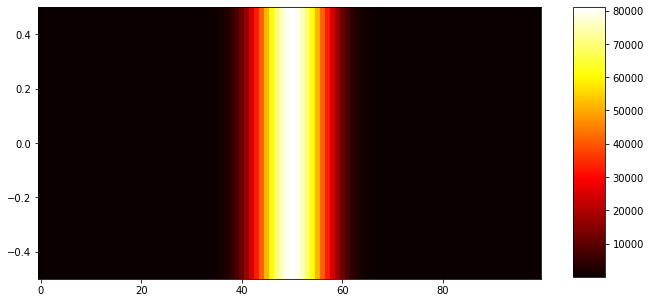

1045222.9154419331

In [209]:
np.sum(abs(E_forward_plane(s, 45)[0]) ** 2)

Просто красивые срезы для 700 нм зазора:

angle: 40.000000


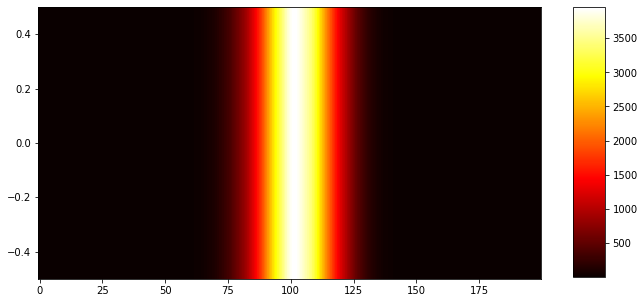

angle: 40.100000


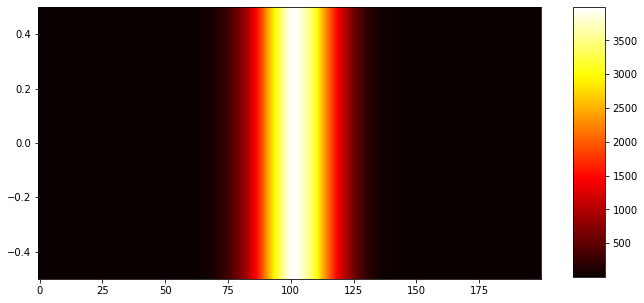

angle: 40.200000


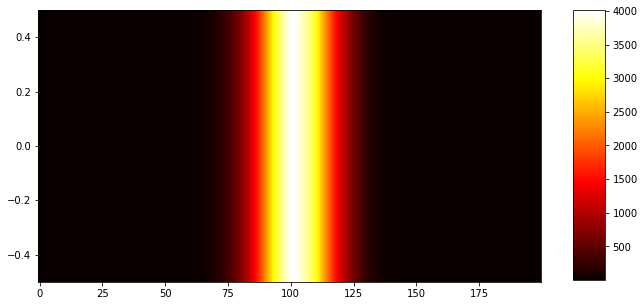

angle: 40.300000


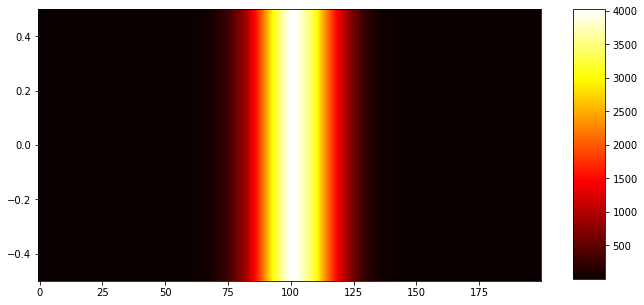

angle: 40.400000


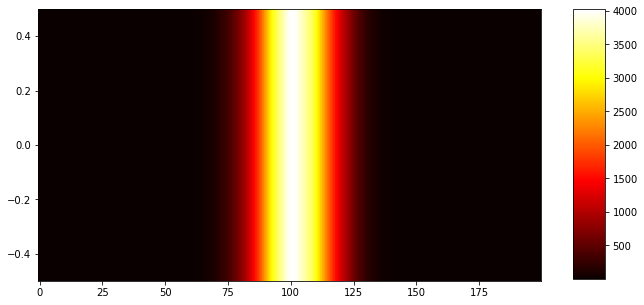

angle: 40.500000


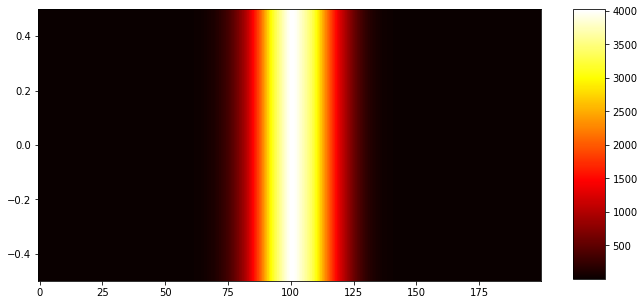

angle: 40.600000


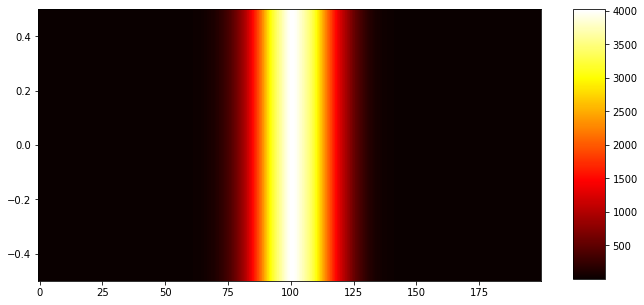

angle: 40.700000


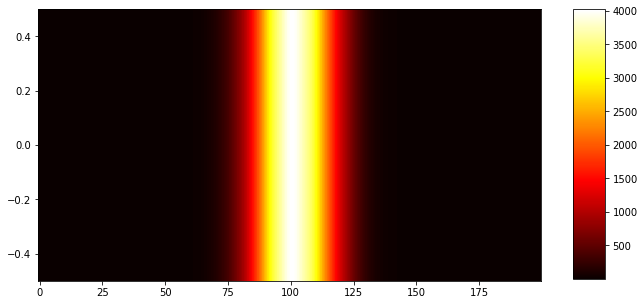

angle: 40.800000


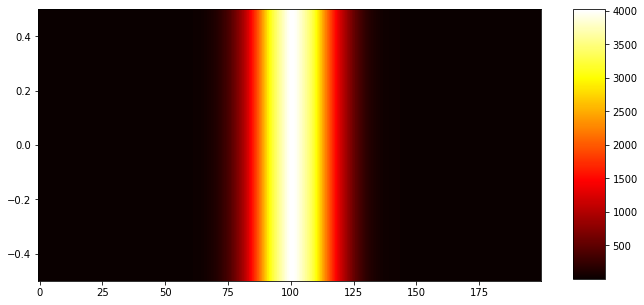

angle: 40.900000


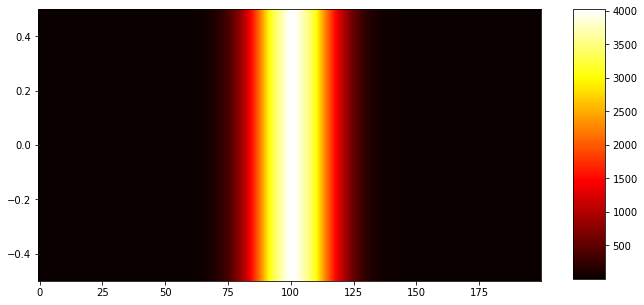

angle: 41.000000


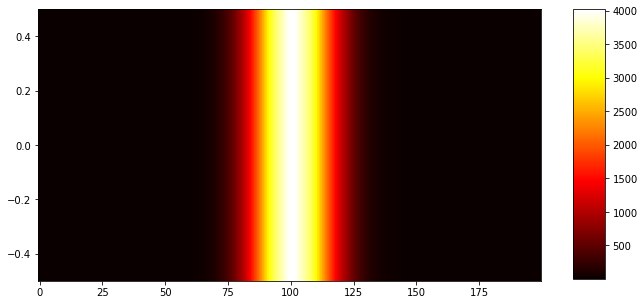

angle: 41.100000


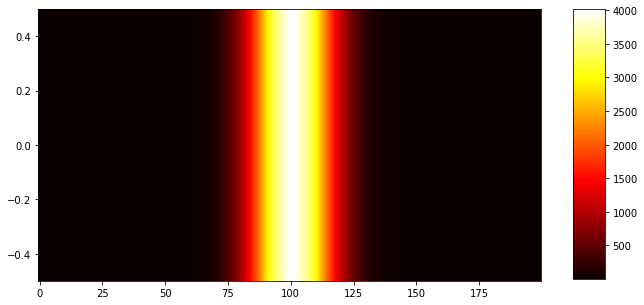

angle: 41.200000


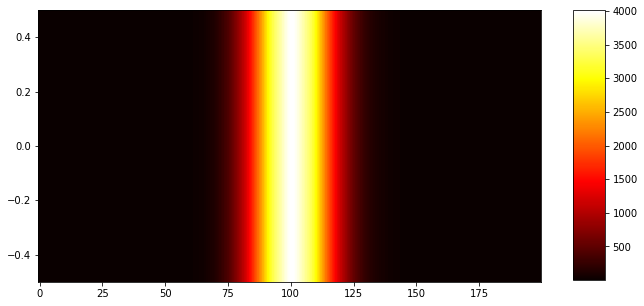

angle: 41.300000


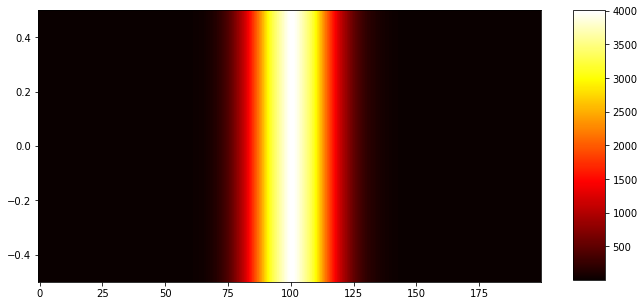

angle: 41.400000


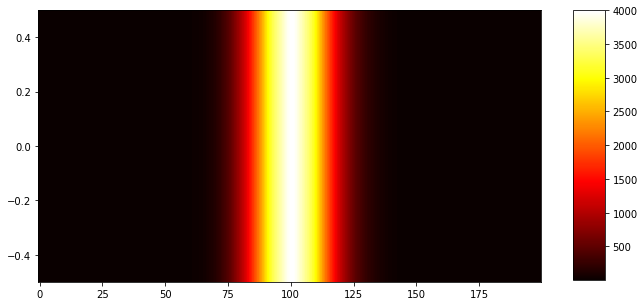

angle: 41.500000


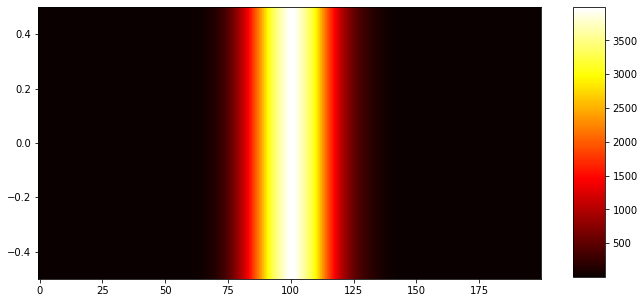

angle: 41.600000


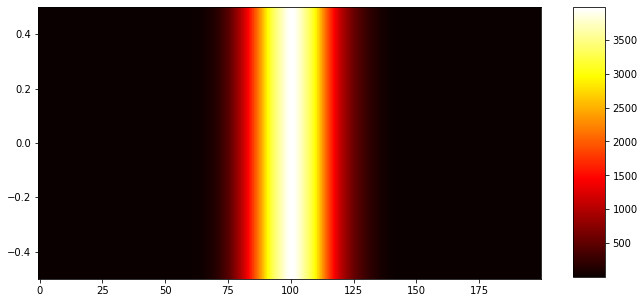

angle: 41.700000


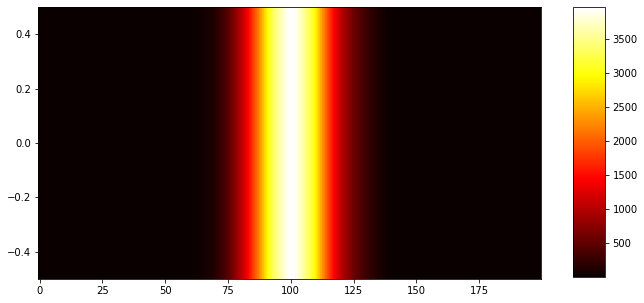

angle: 41.800000


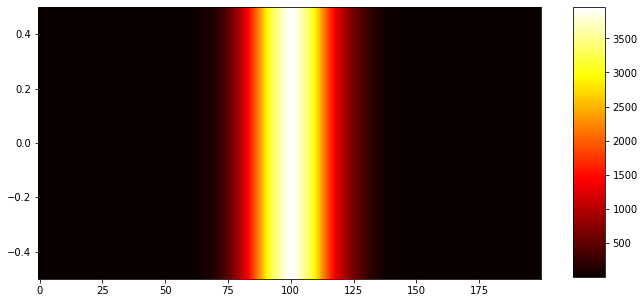

angle: 41.900000


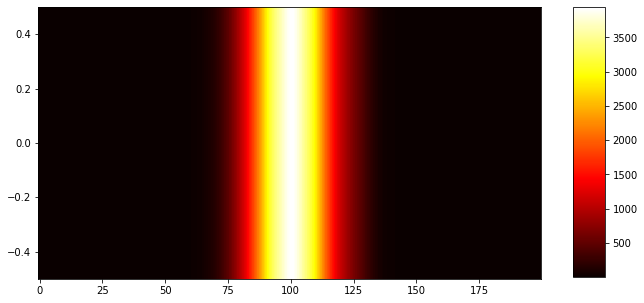

angle: 42.000000


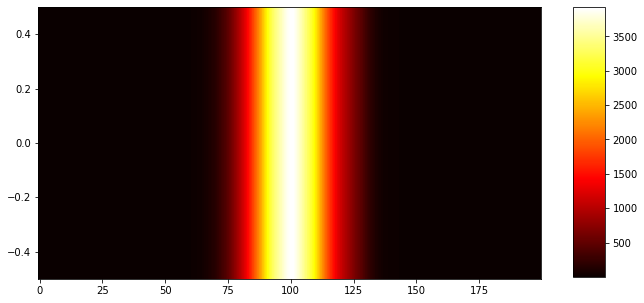

angle: 42.100000


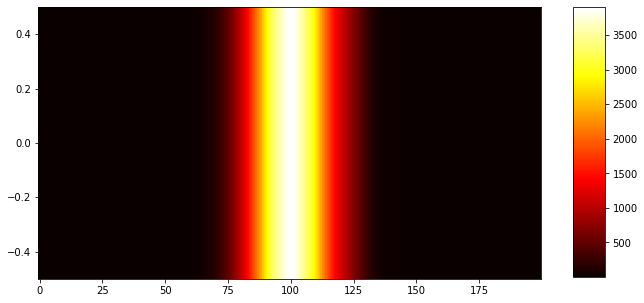

angle: 42.200000


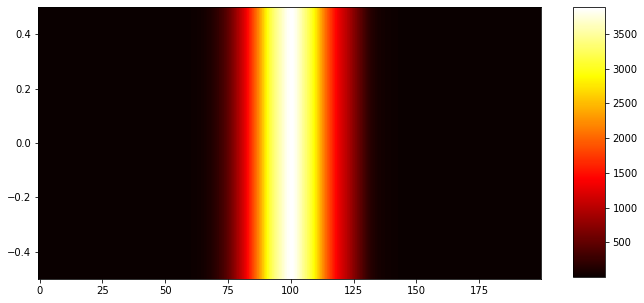

angle: 42.300000


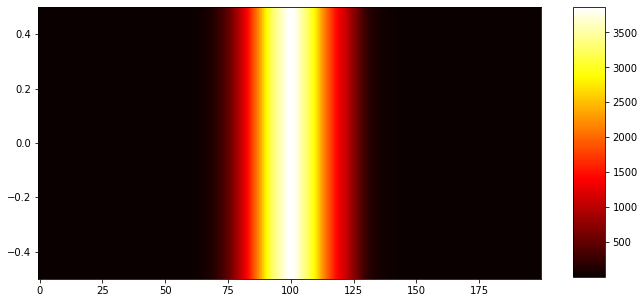

angle: 42.400000


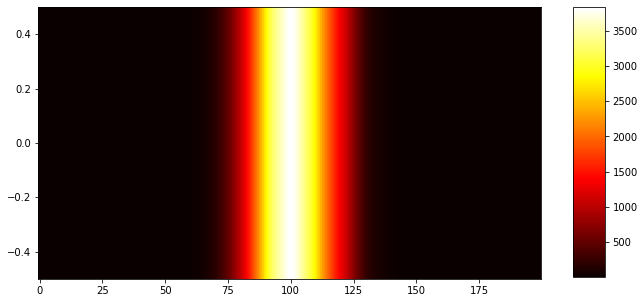

angle: 42.500000


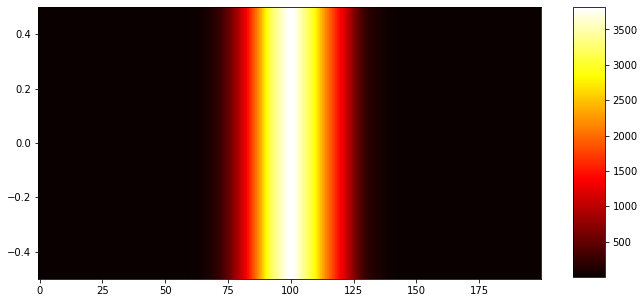

angle: 42.600000


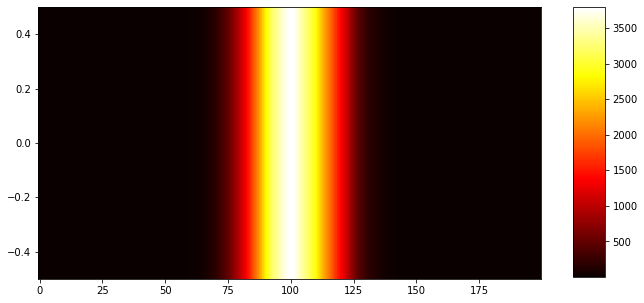

angle: 42.700000


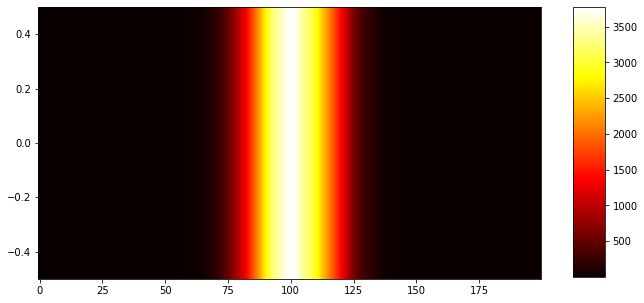

angle: 42.800000


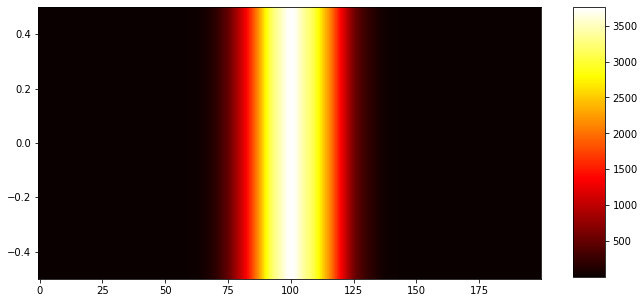

angle: 42.900000


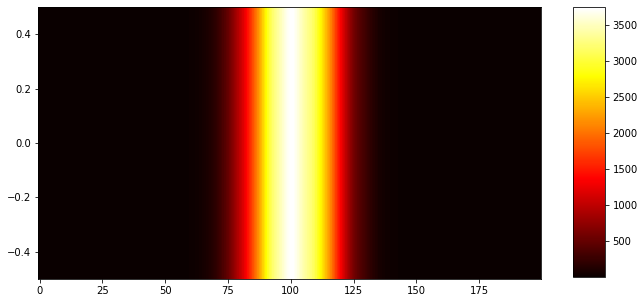

angle: 43.000000


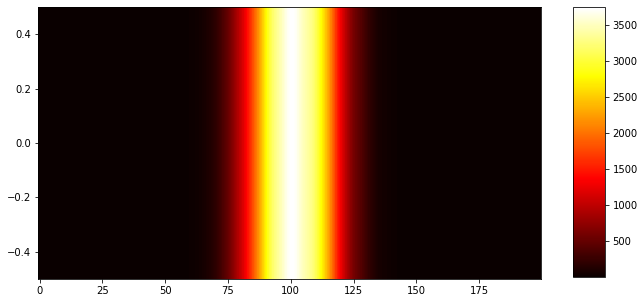

angle: 43.100000


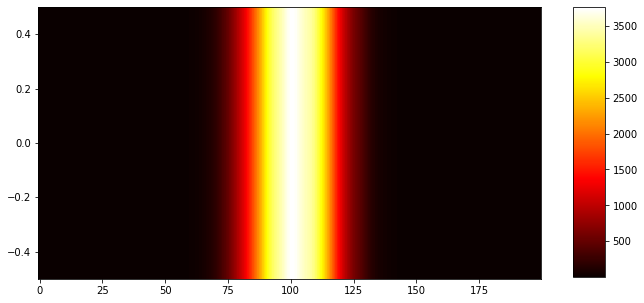

angle: 43.200000


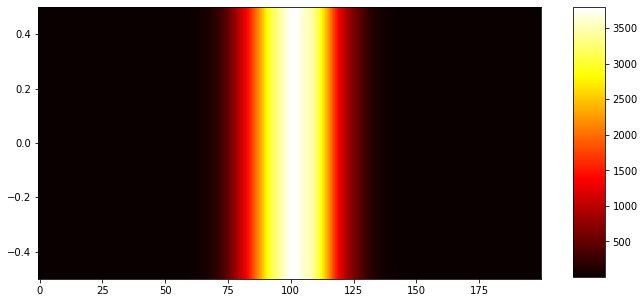

angle: 43.300000


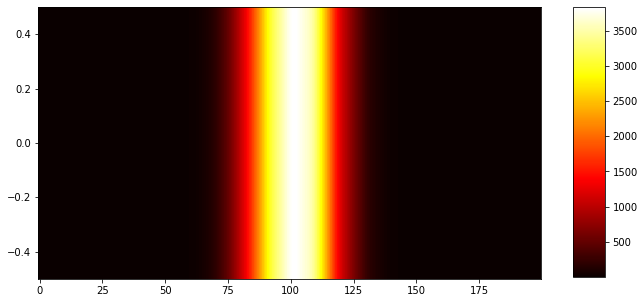

angle: 43.400000


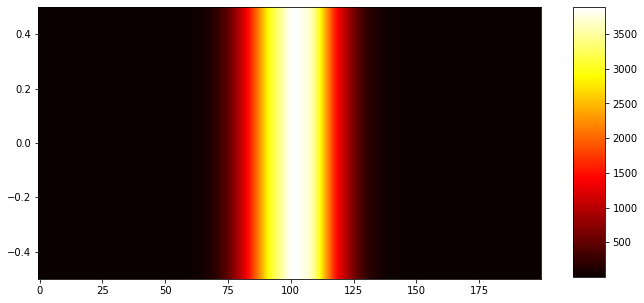

angle: 43.500000


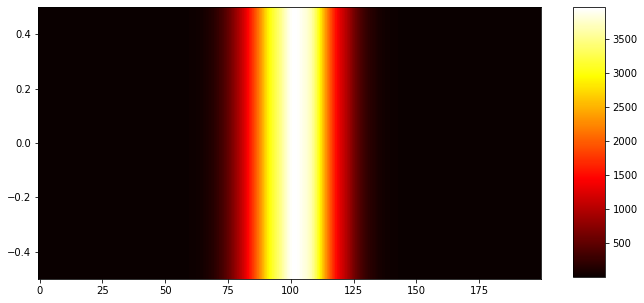

angle: 43.600000


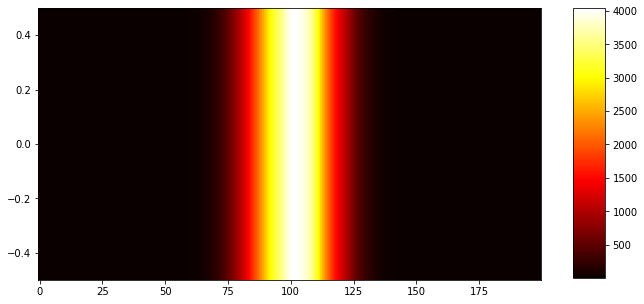

angle: 43.700000


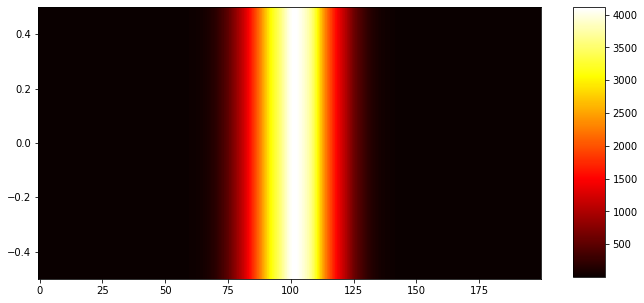

angle: 43.800000


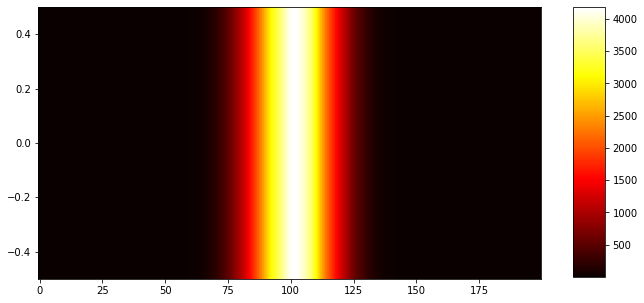

angle: 43.900000


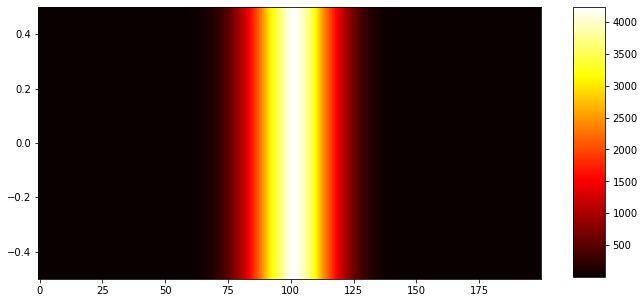

angle: 44.000000


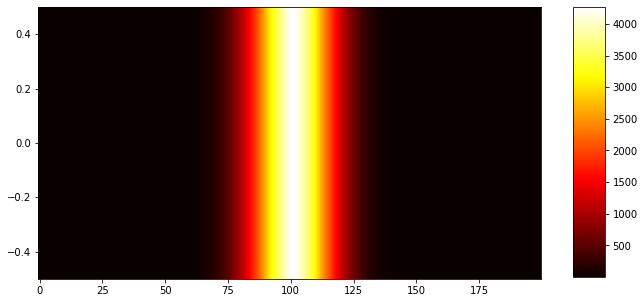

angle: 44.100000


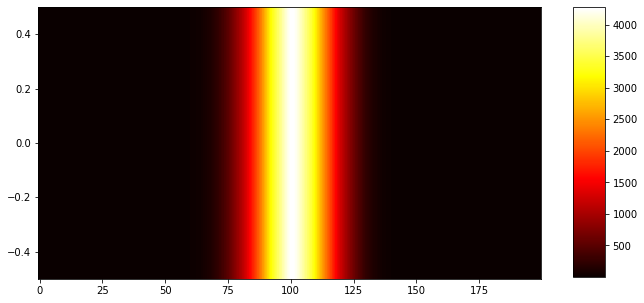

angle: 44.200000


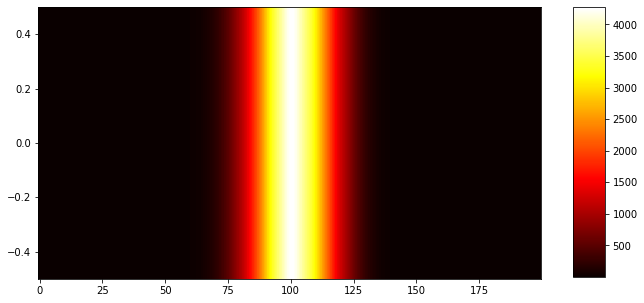

angle: 44.300000


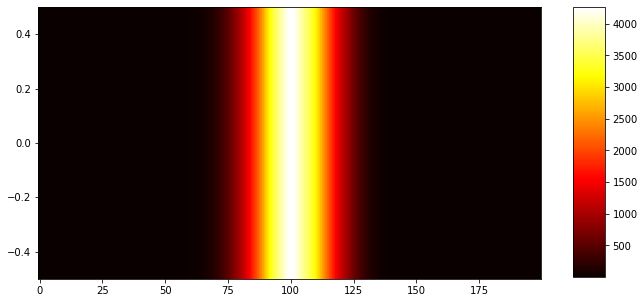

angle: 44.400000


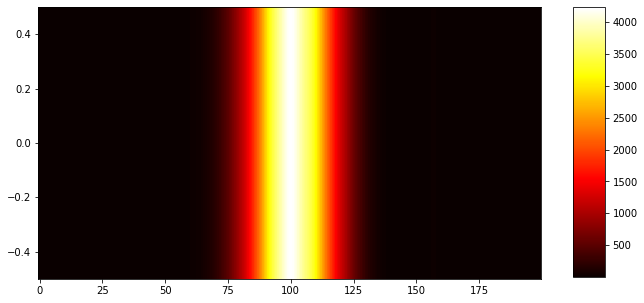

angle: 44.500000


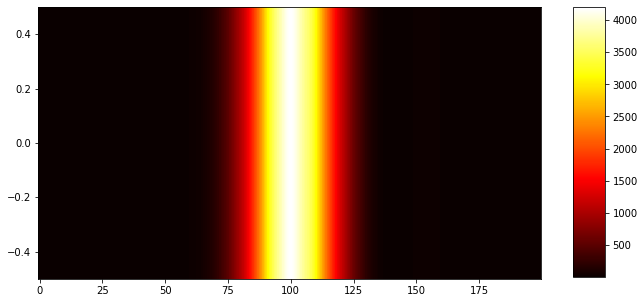

angle: 44.600000


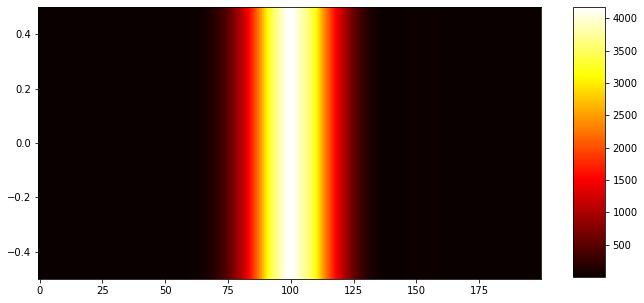

angle: 44.700000


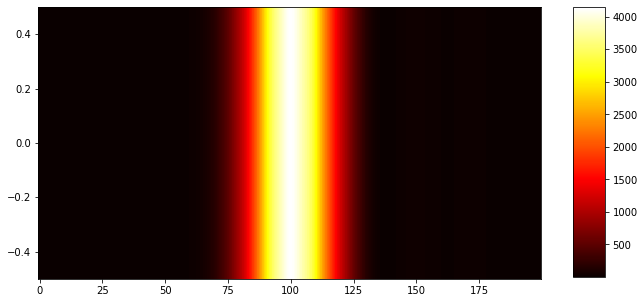

angle: 44.800000


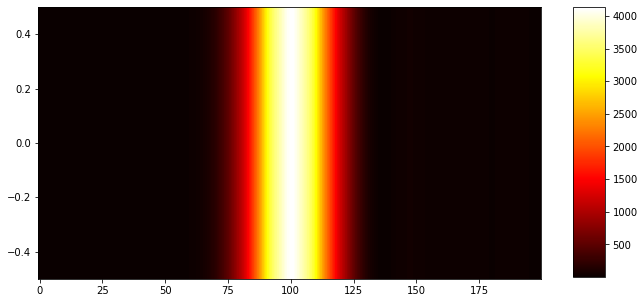

angle: 44.900000


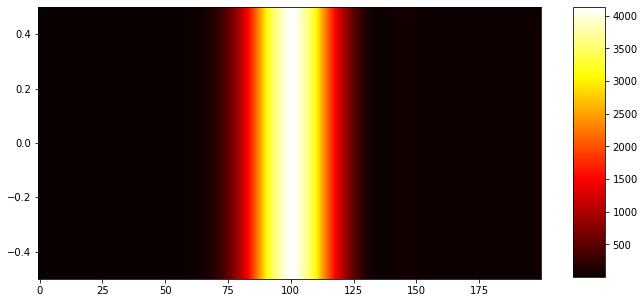

angle: 45.000000


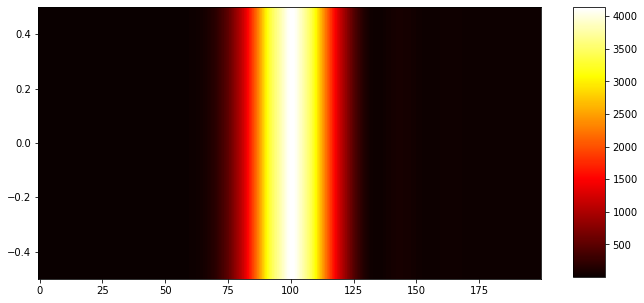

angle: 45.100000


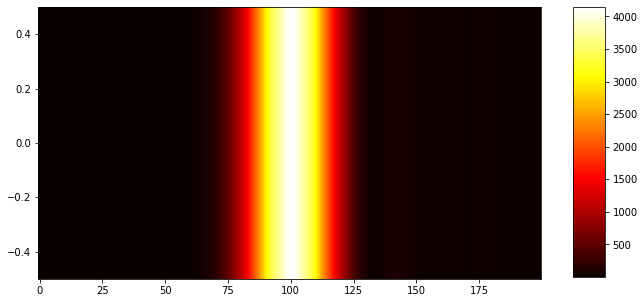

angle: 45.200000


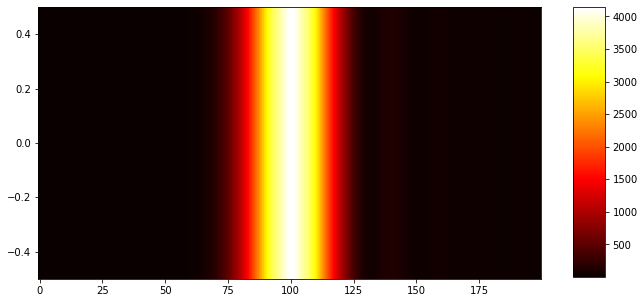

angle: 45.300000


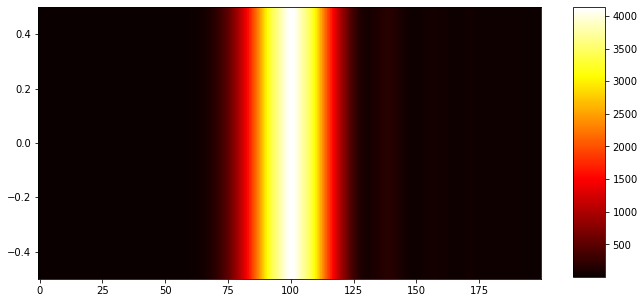

angle: 45.400000


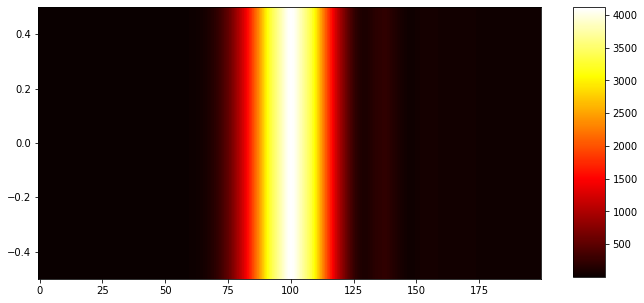

angle: 45.500000


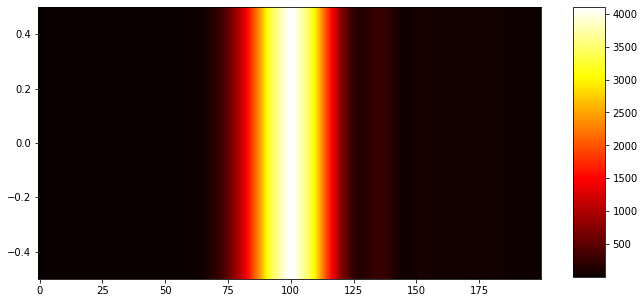

angle: 45.600000


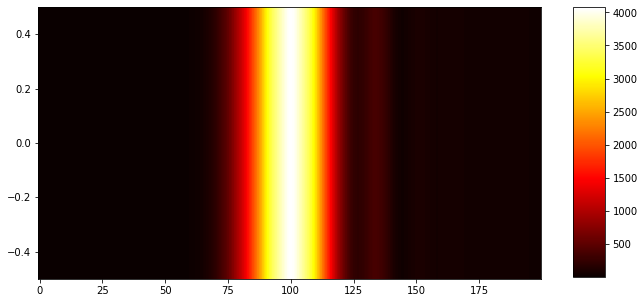

angle: 45.700000


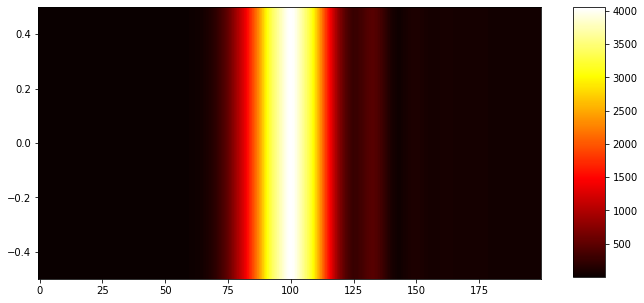

angle: 45.800000


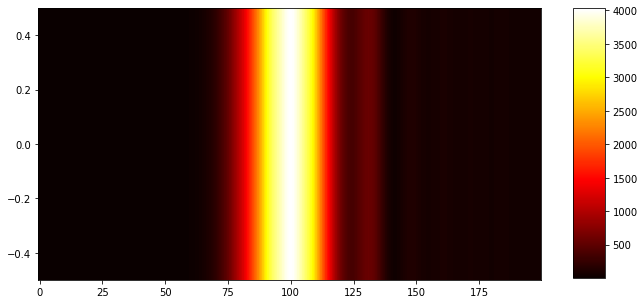

angle: 45.900000


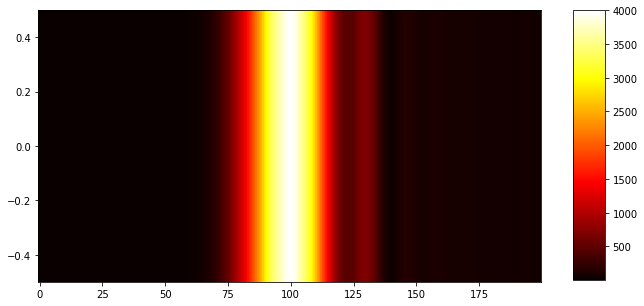

angle: 46.000000


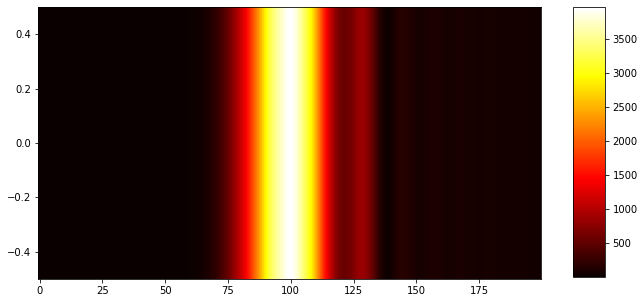

angle: 46.100000


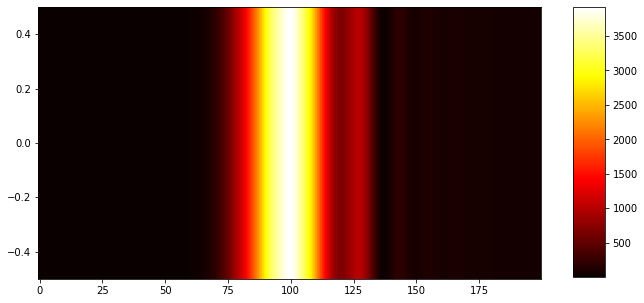

angle: 46.200000


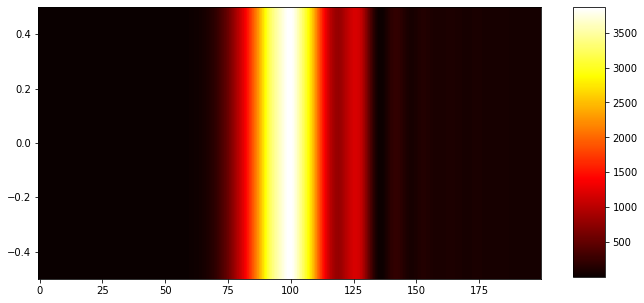

angle: 46.300000


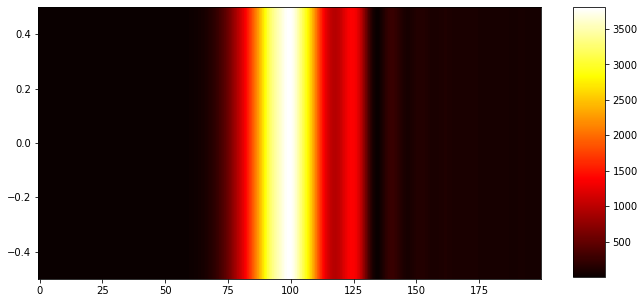

angle: 46.400000


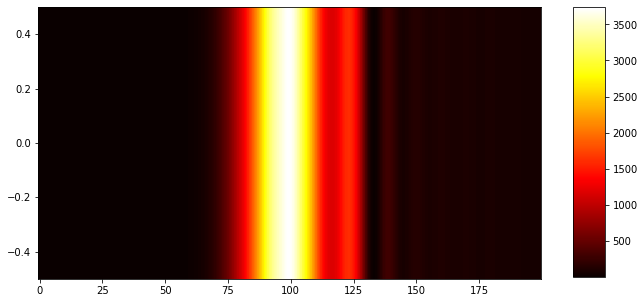

angle: 46.500000


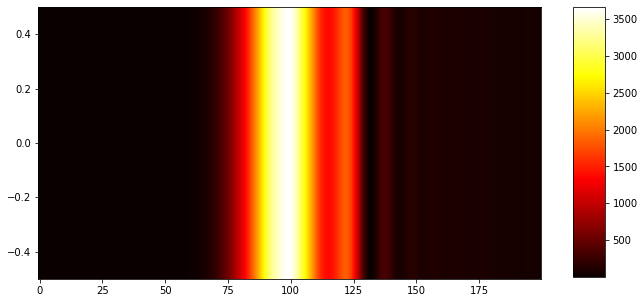

angle: 46.600000


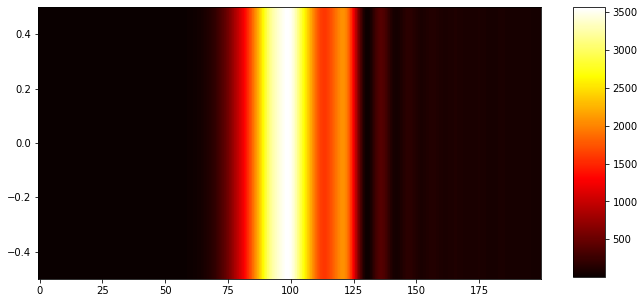

angle: 46.700000


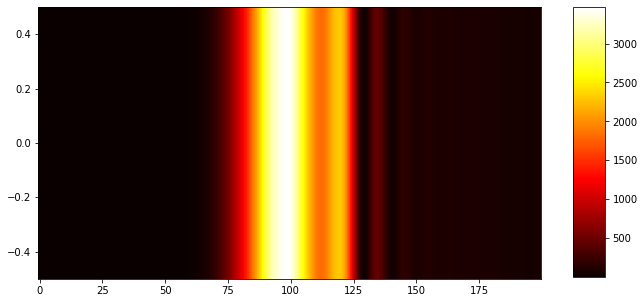

angle: 46.800000


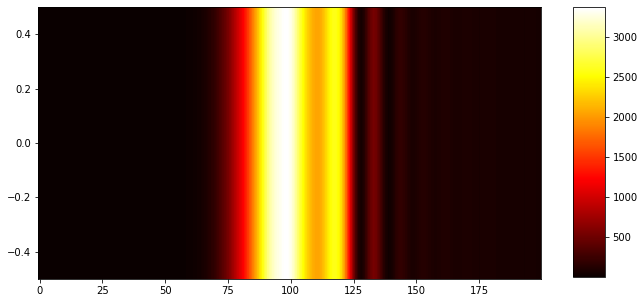

angle: 46.900000


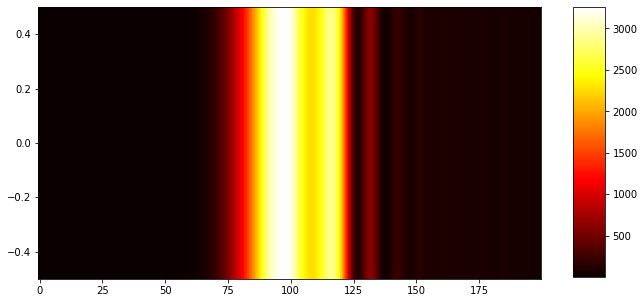

angle: 47.000000


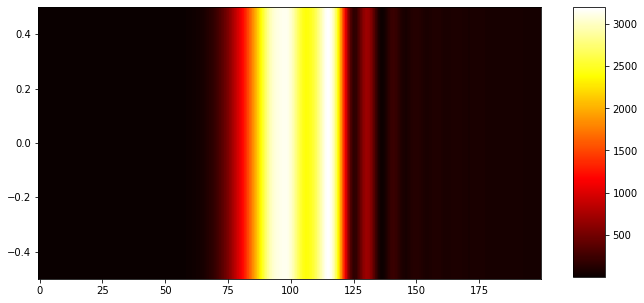

angle: 47.100000


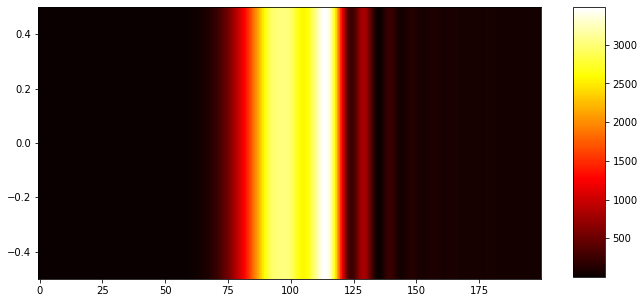

angle: 47.200000


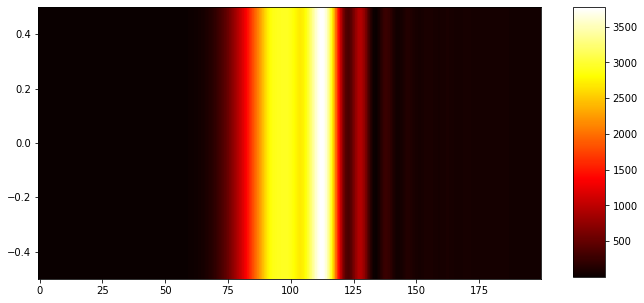

angle: 47.300000


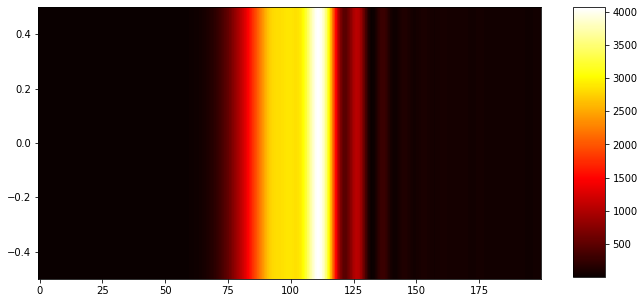

angle: 47.400000


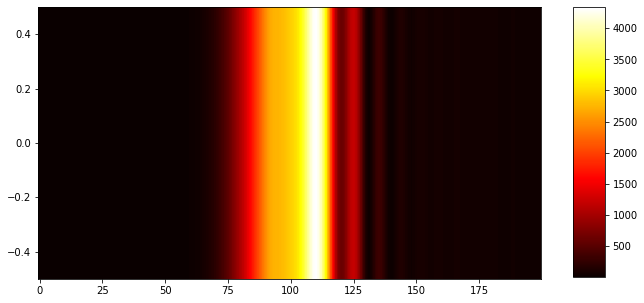

angle: 47.500000


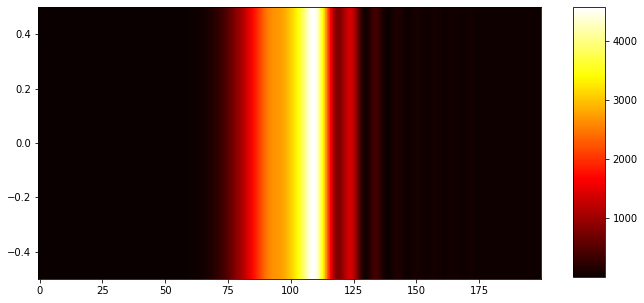

angle: 47.600000


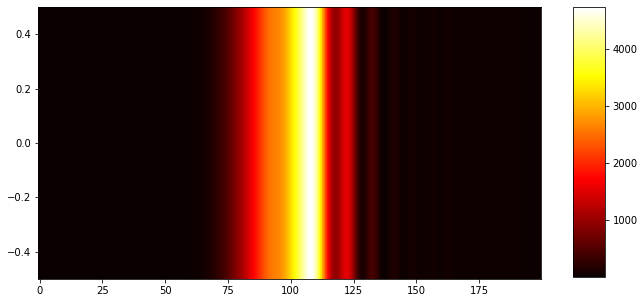

angle: 47.700000


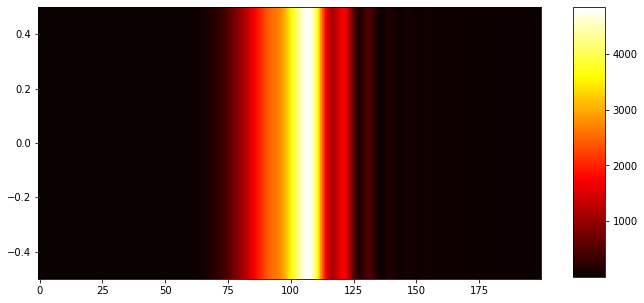

angle: 47.800000


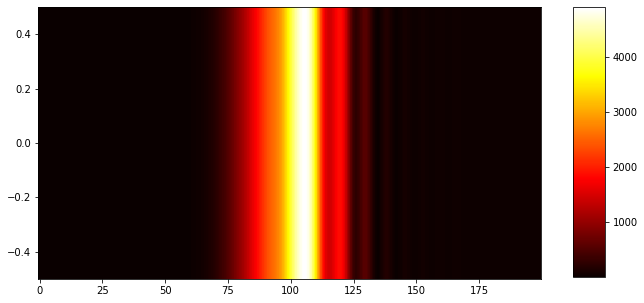

angle: 47.900000


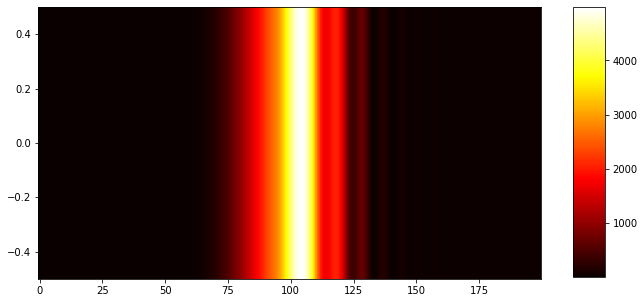

angle: 48.000000


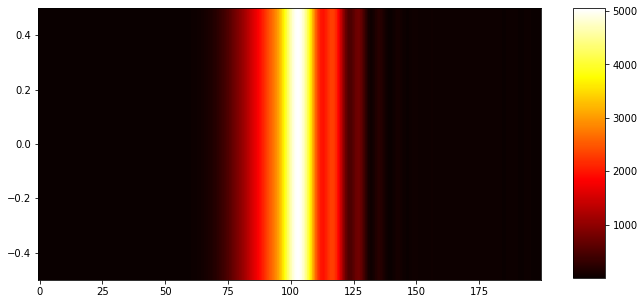

angle: 48.100000


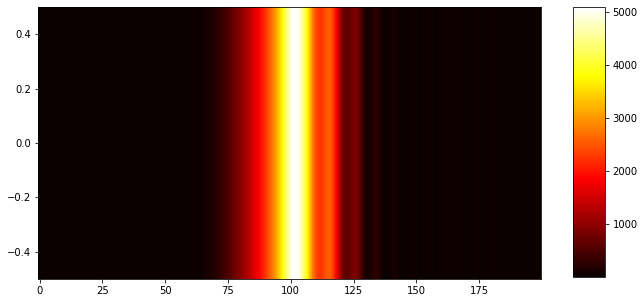

angle: 48.200000


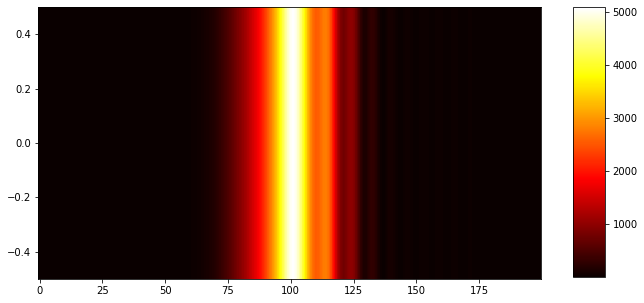

angle: 48.300000


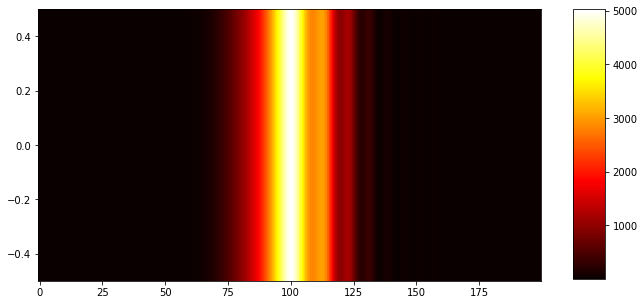

angle: 48.400000


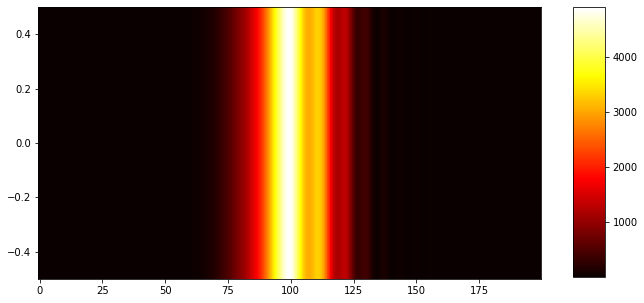

angle: 48.500000


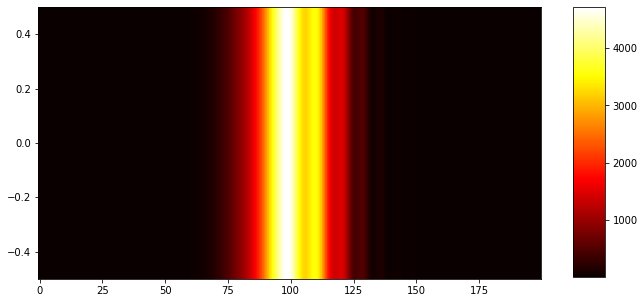

angle: 48.600000


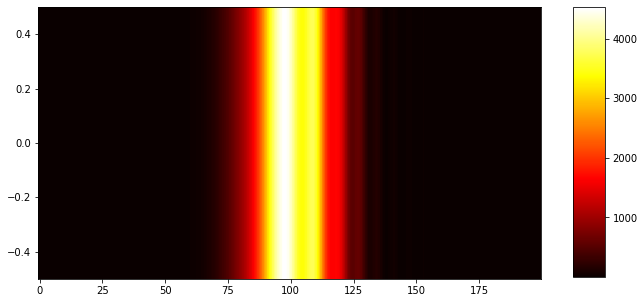

angle: 48.700000


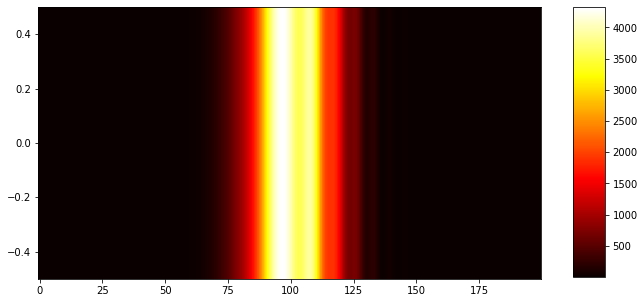

angle: 48.800000


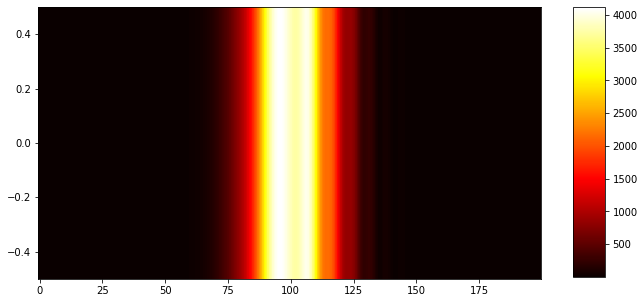

angle: 48.900000


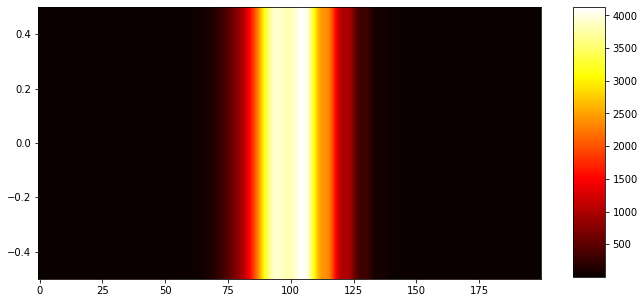

angle: 49.000000


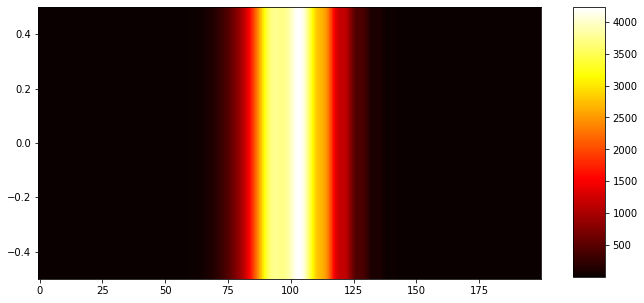

angle: 49.100000


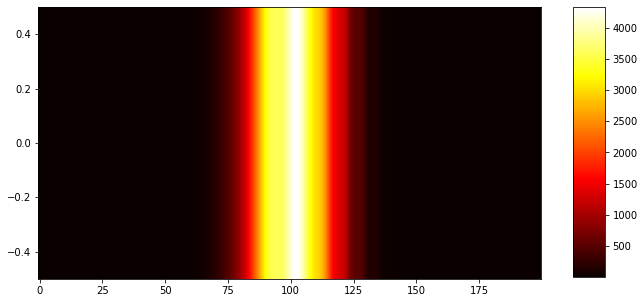

angle: 49.200000


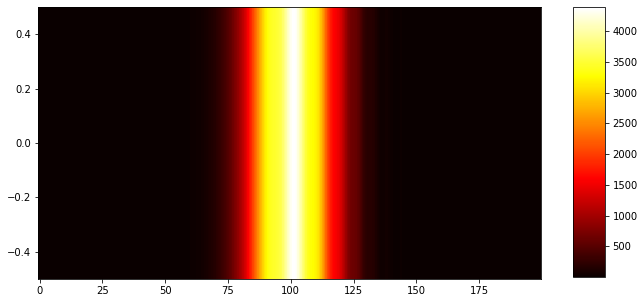

angle: 49.300000


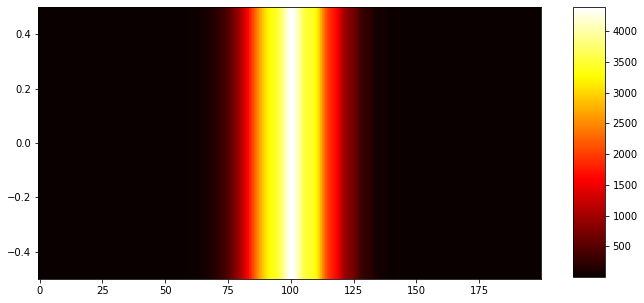

angle: 49.400000


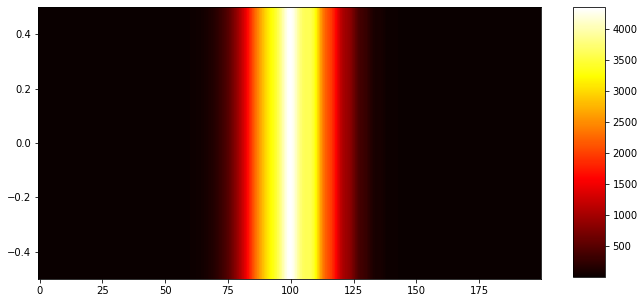

angle: 49.500000


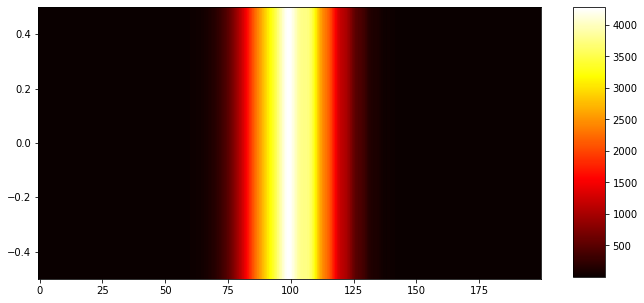

angle: 49.600000


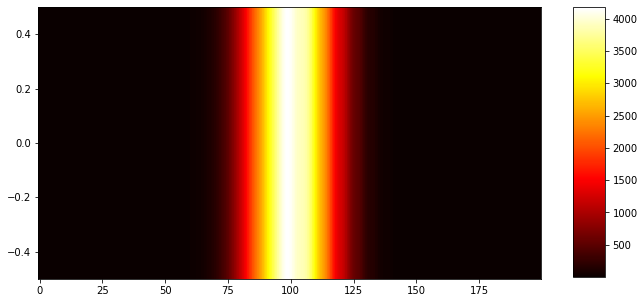

angle: 49.700000


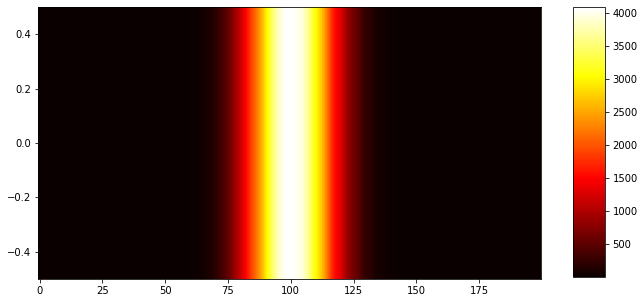

angle: 49.800000


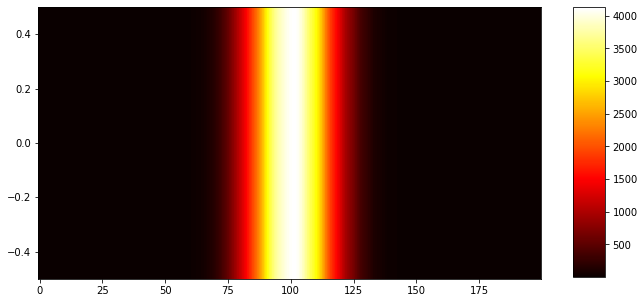

angle: 49.900000


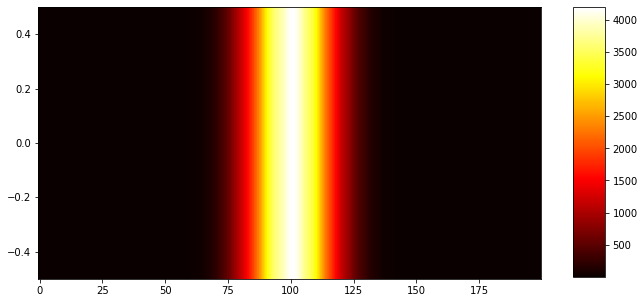

In [194]:
angle_range = np.arange(40, 50, 0.1)
R_gaus = []
for inc_an in angle_range:
    k_x = get_k_x(5)
    k_mkm = k / 1000000.
    k_z = k_mkm * np.cos(np.arcsin(k_x / k_mkm))
    s = S_k(5, k_x).reshape((-1, 1))
    k_matrix = np.vstack((k_x.reshape((1, -1)), k_z.reshape((1, -1))))
    angles = 180 / np.pi * np.arcsin(k_x / k_mkm) + inc_an
    R = vectorize_R(angles).reshape((-1, 1))
    s_r = s * R
    R_gaus.append(np.sum(abs(E_reflected_plane(s_r, inc_an)[0]) ** 2))


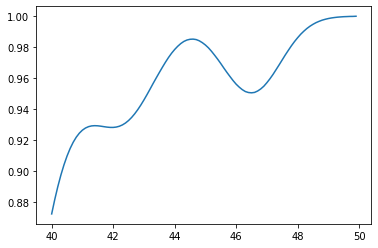

In [192]:
plt.plot(angle_range, np.array(R_gaus) / 130661)

Теперь 300 нм:

In [11]:
wl = 780.
didic = {
    0: {
        'name': 'Среда',
        'n': 1.5 + 0.j
    },
    1: {
        'name': 'Слой',
        'n': 1 + 0.j,
        'd': 300
    },  
    2: {
        'name': 'ФК',
        'n1': 1.45 + 0.j,
        'd1': 204.,
        'n2': 2.07+0.j,
        'd2': 143.,
        'N' : 10
    },
    3: {
        'name': 'Среда',
        'n': 1.52 + 0.j
    }
}
def decor(angles):
    return R_func(didic, wl, angles)
vectorize_R = np.vectorize(decor)

In [15]:
angle_range = np.arange(40, 50, 0.1)
spot_range = np.arange(2.5, 15, 1)
R_spots = []
for ll in spot_range:
    R_gaus = []
    for inc_an in angle_range:
        k_x = get_k_x(ll, 400)
        k_mkm = k / 1000000.
        k_z = k_mkm * np.cos(np.arcsin(k_x / k_mkm))
        s = S_k(ll, k_x).reshape((-1, 1))
        k_matrix = np.vstack((k_x.reshape((1, -1)), k_z.reshape((1, -1))))
        angles = 180 / np.pi * np.arcsin(k_x / k_mkm) + inc_an
        R = vectorize_R(angles).reshape((-1, 1))
        s_r = s * R
        R_gaus.append(np.sum(abs(E_reflected_plane(s_r, inc_an)[0]) ** 2))
    R_spots.append(R_gaus)

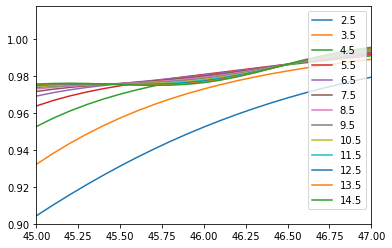

In [17]:
for i, spot in enumerate(spot_range):
    plt.plot(angle_range, np.array(R_spots[i]) / R_spots[i][-1], label=str(spot))
    plt.xlim(left=45, right=47)
    plt.ylim(bottom=0.9)
plt.legend()

### Распеределение интенсивности поля вдоль поверхности ФК

In [15]:
def get_rotation(angle):
    rot_matrix = np.empty((2, 2), dtype = np.complex)
    rot_matrix[0, 0] = cos(np.pi * angle / 180)
    rot_matrix[0, 1] = sin(np.pi * angle / 180)
    rot_matrix[1, 0] = sin(np.pi * angle / 180)
    rot_matrix[1, 1] = -cos(np.pi * angle / 180)
    return rot_matrix


In [ ]:
def decor(angles, wl, didic):
    return R_func(didic, wl, angles)
vectorize_R = np.vectorize(decor)

def transfer_matrix_vec(N1, N2):
    t00 = (N2 + N1) / (2. * N2)
    t01 = (N2 - N1) / (2. * N2)
    t10 = (N2 - N1) / (2. * N2)
    t11 = (N2 + N1) / (2. * N2)
    return np.vstack((t00, t01, t10, t11)).reshape((2, 2, -1)).T

vectorize_N = np.vectorize(N_calculation)

def generate_TMM(didic, angles):
    N1 = vectorize_N(didic[0]['n'], np.pi / 180 * angles, didic[0]['n'])
    N2 = vectorize_N(didic[0]['n'], np.pi / 180 * angles, didic[1]['n'])
    TMMs = transfer_matrix_vec(N1, N2)
    return TMMs    

def E_air_spectrum(s, R, TMMs):
    E_air = np.empty((2, np.size(s)), dtype=np.complex)
    E_inc = np.hstack((s, s * R)).T
    for i in range(np.size(s)):
        E_air[:, i] = TMMs[i] @ E_inc[:, i]
    E_plus = E_air[0].reshape((-1, 1))
    E_minus = E_air[1].reshape((-1, 1))
    return E_plus, E_minus

def get_K_xz_air(k_mkm, k_mkm_gap, angles):
    k_x_b = k_mkm * np.sin(np.pi / 180 * angles)
    k_z_b = np.sqrt(k_mkm_gap ** 2 - k_x_b ** 2, dtype=np.complex)
    k_matrix = np.vstack((k_x_b, k_z_b))
    return k_matrix

def get_defocus_phase(k_mkm, angles, L):
    median_angle = np.pi / 180 * angles[np.size(angles) // 2]
    h_shift = L * np.cos(median_angle)
    x_shift = L * np.sin(median_angle)
    k_x = k_mkm * np.sin(np.pi / 180 * angles)
    k_z = k_mkm * np.cos(np.pi / 180 * angles)
    phase_shift = k_x * x_shift + k_z * h_shift
    return np.exp(1.0j * phase_shift).reshape((-1, 1))
    

def cut_BSW_intesity(angles_range, X, struct, a=5, Z=0.3, L=0):
    '''
    set default parameters range
    '''
    wl = 780.

    '''
    get comon variables
    '''
    k = 2 * np.pi * 1000000000 / wl * struct[0]['n'].real
    k_mkm = k / 1000000.
    k_mkm_gap = k_mkm / struct[0]['n'].real * struct[1]['n'].real
    k_x = get_k_x(a=a, N_x=401, decr_times=10)
    dk = k_x[1] - k_x[0]
    s = S_k(a, k_x).reshape((-1, 1))
    r_pos = np.empty((1, 2))
    E_destr = np.empty((np.size(angles_range), np.size(X)), dtype=np.complex)
    for j, alpha in enumerate(angles_range):
        angles = 180 / np.pi * np.arcsin(k_x / k_mkm) + alpha
        R = vectorize_R(angles, wl, struct).reshape((-1, 1))
        TMMs = generate_TMM(struct, angles)
        k_xz = get_K_xz_air(k_mkm, k_mkm_gap, angles)
        defocus_phase = get_defocus_phase(k_mkm, angles, L)
        E_plus, E_minus = E_air_spectrum(s, R, TMMs)
        E_forward = np.zeros(np.size(X), dtype=np.complex)
        E_backward = np.zeros(np.size(X), dtype=np.complex)
        r_pos[0,1] = Z
        for i, x in enumerate(X):
            r_pos[0, 0] = x
            E_forward[i] = np.exp(1.0j * r_pos @ k_xz, dtype=np.complex) @ (E_plus * defocus_phase) * dk
            E_backward[i] = np.exp(1.0j * r_pos @ k_xz.conj(), dtype=np.complex) @(E_minus * defocus_phase) * dk
        E_destr[j] = E_forward + E_backward
    return E_destr
        
"""
kek = np.vstack((X, Z * np.ones(np.size(X)))).T
E_forward = np.exp(1.0j * kek @ k_matrix, dtype=np.complex) @ E_plus * dk
E_backward = np.exp(1.0j * kek @ k_matrix.conj(), dtype=np.complex) @ E_minus * dk
E_destr[j] = (E_forward + E_backward).T
"""


CPU times: user 1min 43s, sys: 3.72 ms, total: 1min 43s
Wall time: 1min 43s


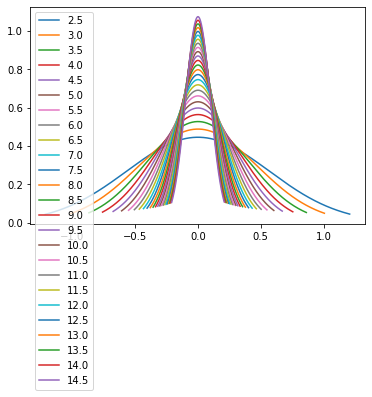

In [169]:
%%time
didic = {
    0: {'name': 'Среда', 'n': 1.5 + 0.j},
    1: {'name': 'Слой',  'n': 1 + 0.j, 'd': 300},  
    2: {'name': 'ФК', 'N' : 10,
        'n1': 1.45 + 0.00002j, 'd1': 204.,
        'n2': 2.07 + 0.00002j, 'd2': 143.},
    3: {'name': 'Среда', 'n': 1.52 + 0.j }
}

angles_range = np.arange(44, 50, 0.05)
X_range = np.arange(-10, 60, 1)
spot_range = np.arange(2.5, 15, 0.5)
E_slices = []
for w in spot_range:
    E_slices.append(cut_BSW_intesity(angles_range, X_range, didic, w, didic[1]['d'] / 1000, 0))
#plot_2Dmap(E_bsw, [X_range.min(), X_range.max(), angles_range.min(), angles_range.max()])

In [170]:
def get_max_angle(E_bsw, return_shift=None, plot_I_a=None, plot_I_x=None):
    I = np.abs(E_bsw) ** 2
    I_max = []
    for line in I:
        I_max.append(np.max(line))
    if plot_I_a != None:
        plt.plot(angles_range, I_max)
        plt.grid()
        plt.xlabel("Inc angle")
        plt.ylabel("Intensity")
    angle_max = angles_range[np.argmax(I_max)]
    if return_shift != None:
        if plot_I_x != None:
            plt.plot(X_range, I[np.argmax(I_max)])
        shift = X_range[np.argmax(I[np.argmax(I_max)])]
        return [angle_max, shift, np.max(I)]
    print("I_max: ", np.max(I_max), "angle_max: ", angles_range[np.argmax(I_max)])
    return [angle_max]

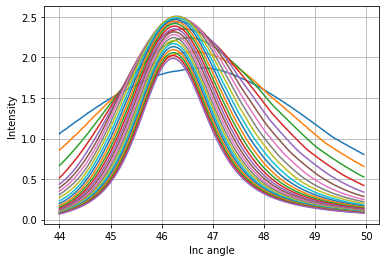

In [171]:
max_angles = []
x_max = []
max_int = []
for i in range(len(spot_range)):
    E_bsw = E_slices[i]
    res = get_max_angle(E_bsw, True, True)
    max_angles.append(res[0])
    x_max.append(res[1])
    max_int.append(res[2])

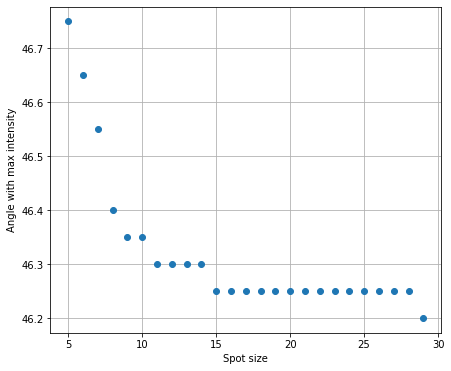

In [255]:
plt.figure(figsize=(7, 6))
plt.plot(2 * spot_range, max_angles, 'o')
plt.xlabel("Spot size")
plt.ylabel("Angle with max intensity")
plt.grid()

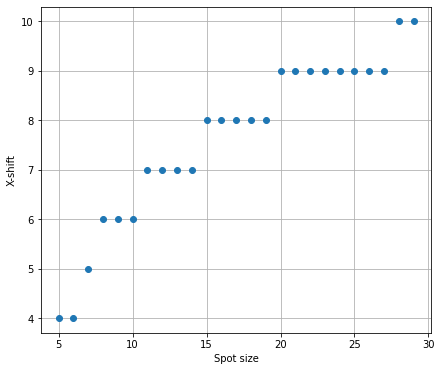

In [254]:
plt.figure(figsize=(7, 6))
plt.plot(2 * spot_range, x_max, 'o')
plt.xlabel("Spot size")
plt.ylabel("X-shift")
plt.grid()

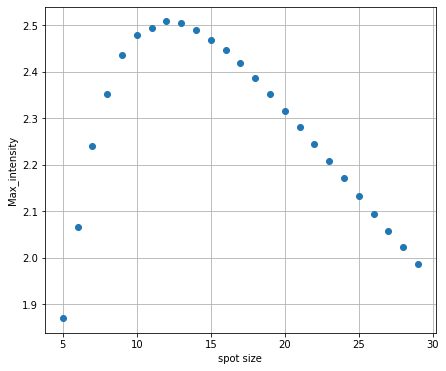

In [253]:
plt.figure(figsize=(7, 6))
plt.plot(2 * spot_range, max_int, 'o')
plt.ylabel("Max_intensity")
plt.xlabel("spot size")
plt.grid()

Spot size:  5.0 angle:  46.75 shift:  4


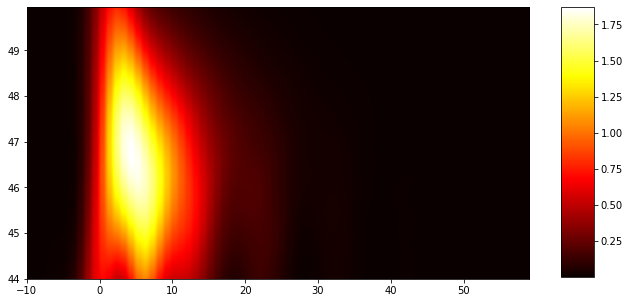

Spot size:  6.0 angle:  46.65 shift:  4


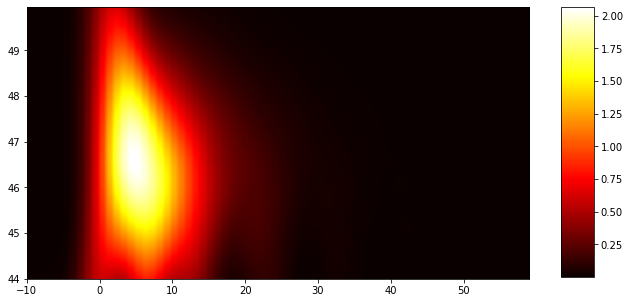

Spot size:  7.0 angle:  46.55 shift:  5


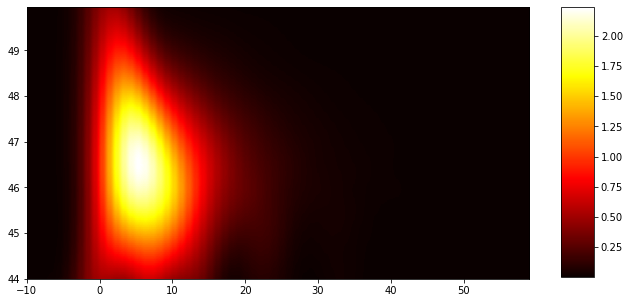

Spot size:  8.0 angle:  46.4 shift:  6


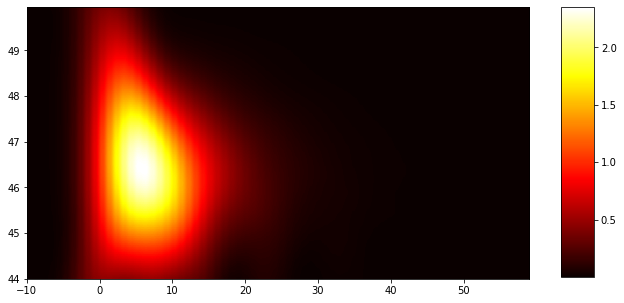

Spot size:  9.0 angle:  46.35 shift:  6


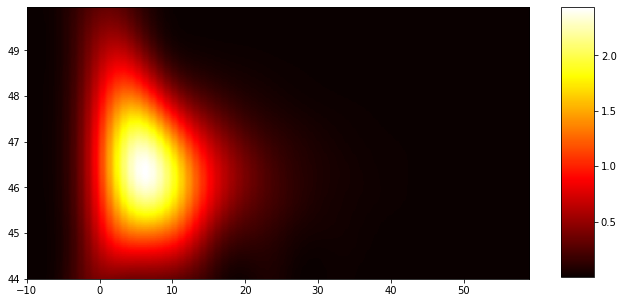

Spot size:  10.0 angle:  46.35 shift:  6


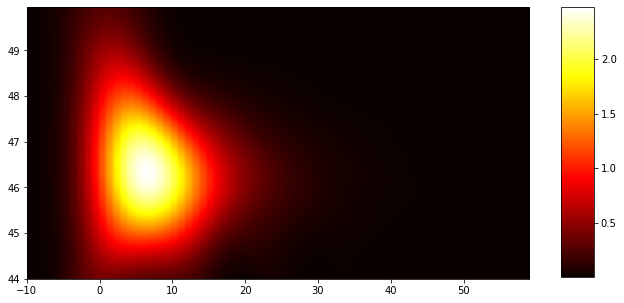

Spot size:  11.0 angle:  46.3 shift:  7


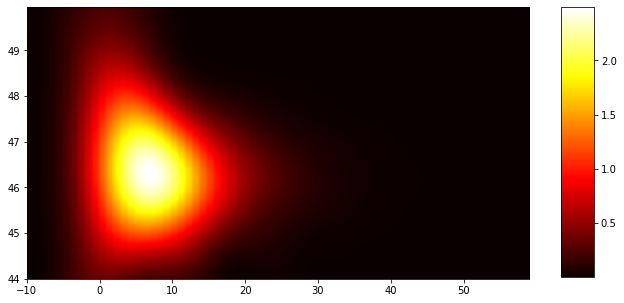

Spot size:  12.0 angle:  46.3 shift:  7


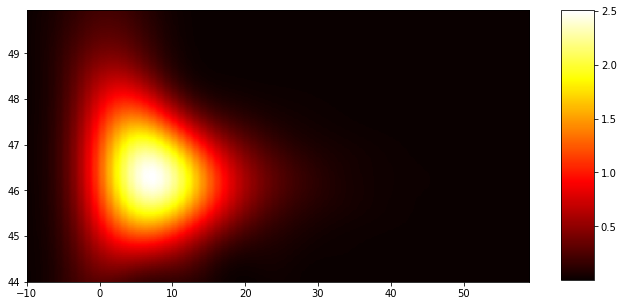

Spot size:  13.0 angle:  46.3 shift:  7


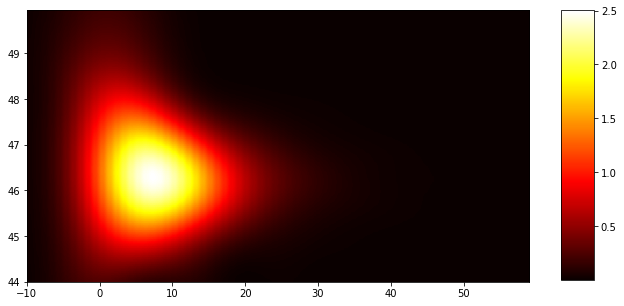

Spot size:  14.0 angle:  46.3 shift:  7


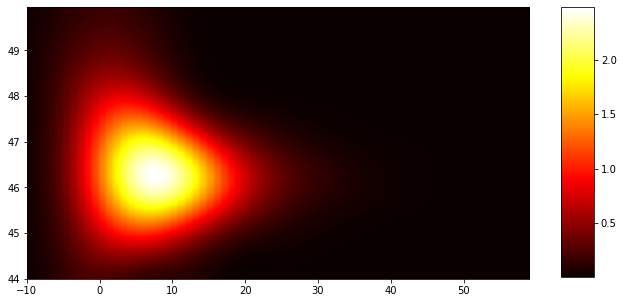

Spot size:  15.0 angle:  46.25 shift:  8


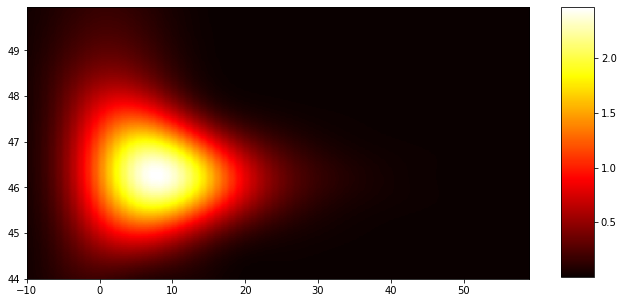

Spot size:  16.0 angle:  46.25 shift:  8


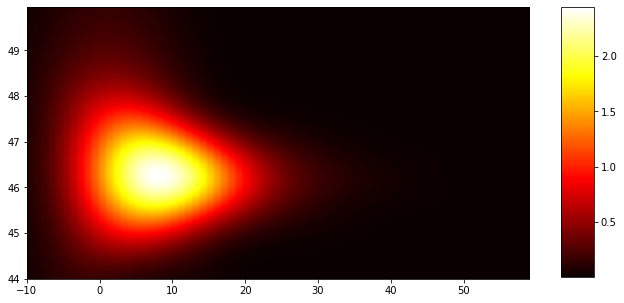

Spot size:  17.0 angle:  46.25 shift:  8


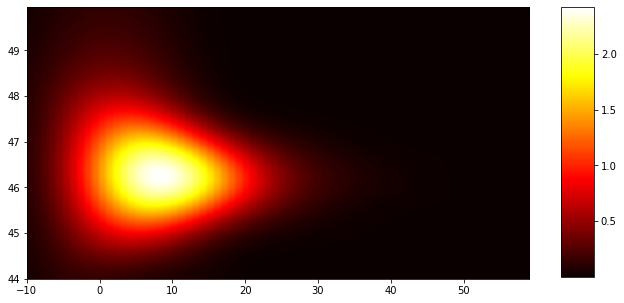

Spot size:  18.0 angle:  46.25 shift:  8


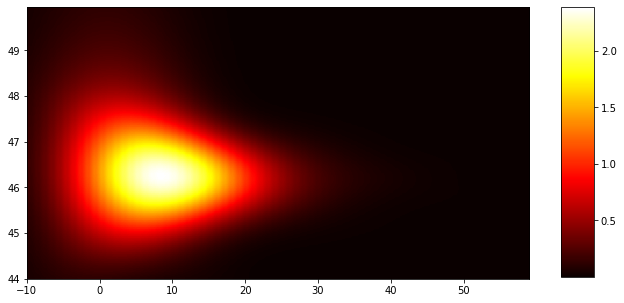

Spot size:  19.0 angle:  46.25 shift:  8


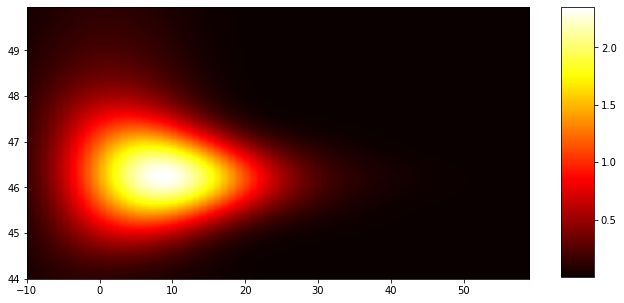

Spot size:  20.0 angle:  46.25 shift:  9


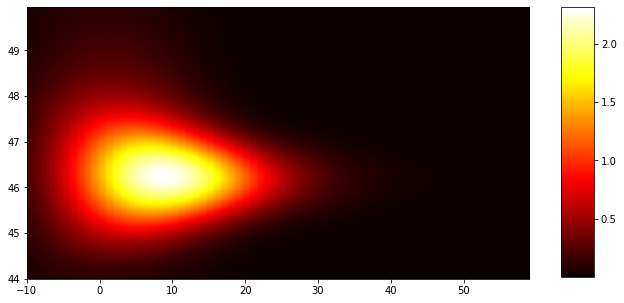

Spot size:  21.0 angle:  46.25 shift:  9


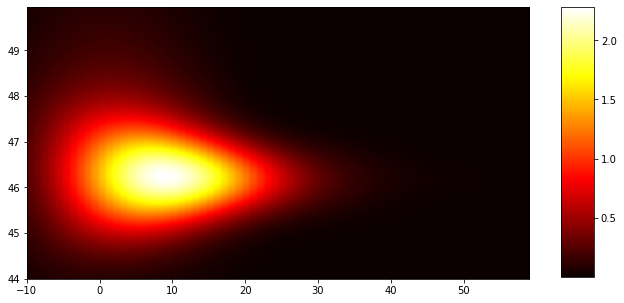

Spot size:  22.0 angle:  46.25 shift:  9


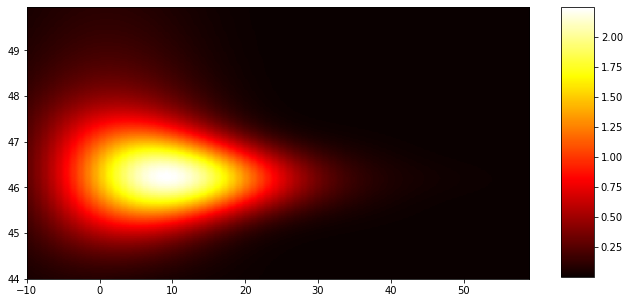

Spot size:  23.0 angle:  46.25 shift:  9


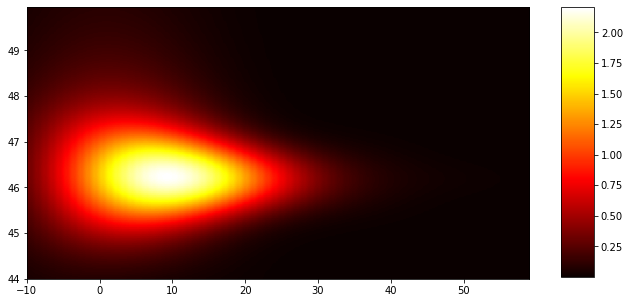

Spot size:  24.0 angle:  46.25 shift:  9


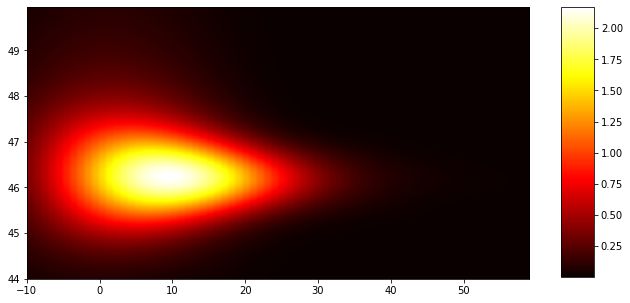

Spot size:  25.0 angle:  46.25 shift:  9


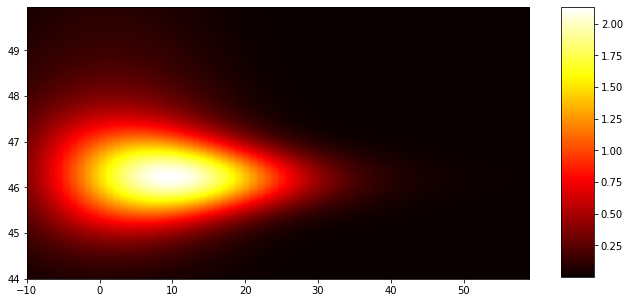

Spot size:  26.0 angle:  46.25 shift:  9


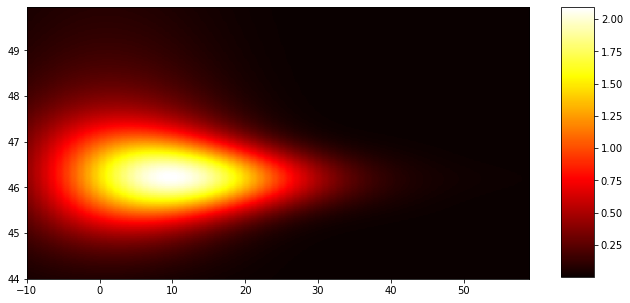

Spot size:  27.0 angle:  46.25 shift:  9


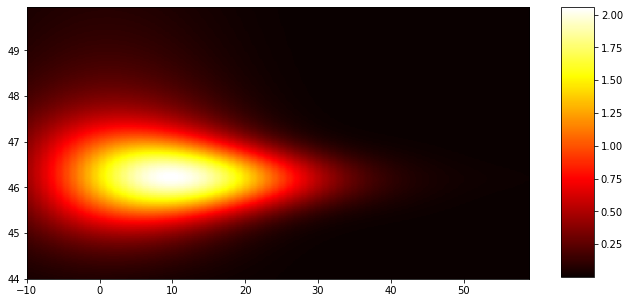

Spot size:  28.0 angle:  46.25 shift:  10


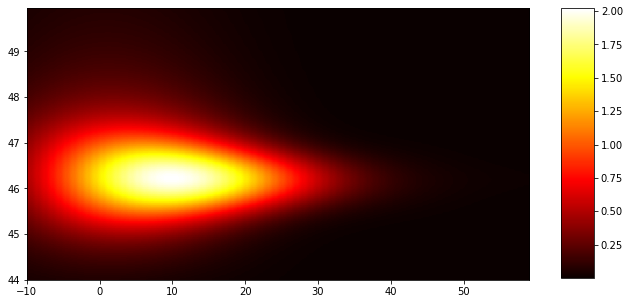

Spot size:  29.0 angle:  46.2 shift:  10


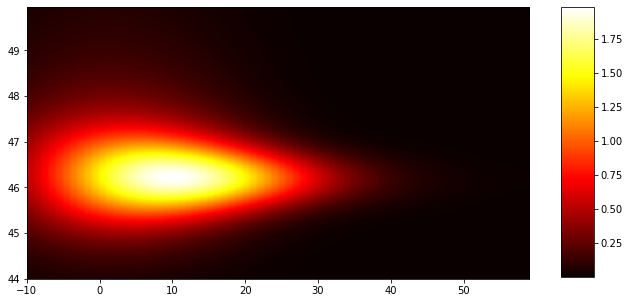

In [174]:
for i, E in enumerate(E_slices):
    max_params = get_max_angle(E, True)
    print("Spot size: ", 2 * spot_range[i], "angle: ", max_params[0], "shift: ", max_params[1])
    plot_2Dmap(E, [X_range.min(), X_range.max(), angles_range.min(), angles_range.max()])


## Интенсивность от d, $\alpha$, x

In [363]:
%%time
didic = {
    0: {
        'name': 'Среда',
        'n': 1.5 + 0.j
    },
    1: {
        'name': 'Слой',
        'n': 1 + 0.j,
        'd': 300
    },  
    2: {
        'name': 'ФК',
        'n1': 1.45 + 0.00002j,
        'd1': 204.,
        'n2': 2.07+0.00002j,
        'd2': 143.,
        'N' : 10
    },
    3: {
        'name': 'Среда',
        'n': 1.52 + 0.j
    }
}

angles_range = np.arange(45, 49.1, 0.1)
X_range = np.arange(-10, 60, 1)
gap_range = np.arange(200, 520, 20)

def I_x_a_d(angles_range, gap_range, didic, X_range, a, defocus):
    E_xad = []
    for air_gap in gap_range:
        didic[1]['d'] = air_gap
        E_xad.append(cut_BSW_intesity(angles_range, X_range, didic, a, didic[1]['d'] / 1000, defocus))
    return E_xad
E_slice2 = I_x_a_d(angles_range, gap_range, didic, X_range, 5, -100)

CPU times: user 27.5 s, sys: 0 ns, total: 27.5 s
Wall time: 27.5 s


$\alpha \in [45, 49]$ шаг 0.1,   
x $\in$ [-10, 60] мкм,  
d $\in$ [200, 500] нм, шаг  20 нм


In [365]:
def get_I_alpha_d(data, angles_range, gap_range):
    I_angle_gap_x = np.abs(data) ** 2
    I_max_gap_angle = np.empty((np.size(gap_range), np.size(angles_range)))
    for i, I_gap_slice in enumerate(I_angle_gap_x):
        I_max_gap_angle[i] = np.max(I_gap_slice, axis=1)
    info = "Gap_max: " + str(gap_range[np.argmax(I_max_gap_angle) // np.size(angles_range)]) + \
          " Angle_max: " + str(angles_range[np.argmax(I_max_gap_angle) % np.size(angles_range)])
    return I_max_gap_angle, info

#### w = 7 мкм

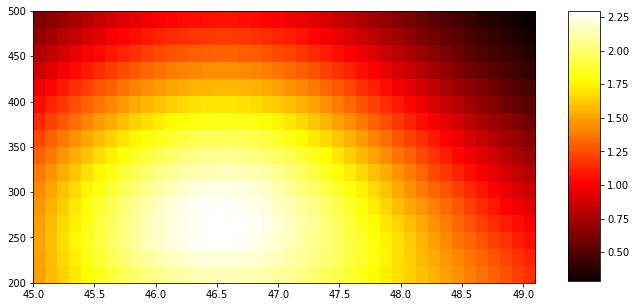

Gap_max:  260 Angle_max:  46.5


In [229]:
get_I_alpha_d()

#####  7 мкм с перефокусом 100 мкм

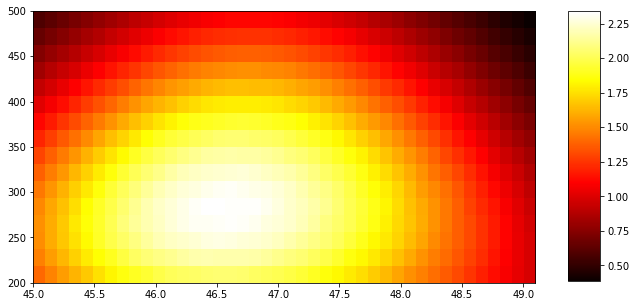

Gap_max:  280 Angle_max:  46.5


In [226]:
get_I_alpha_d()

#### w = 10 мкм

In [238]:
''' можно посмотреть как изменяется поле в волны при изменении зазора'''
#for i, E in enumerate(E_slice2):
#    print("gap: ", gap_range[i])
#    plot_2Dmap(E, [X_range.min(), X_range.max(), angles_range.min(), angles_range.max()])

' можно посмотреть как изменяется поле в волны при изменении зазора'

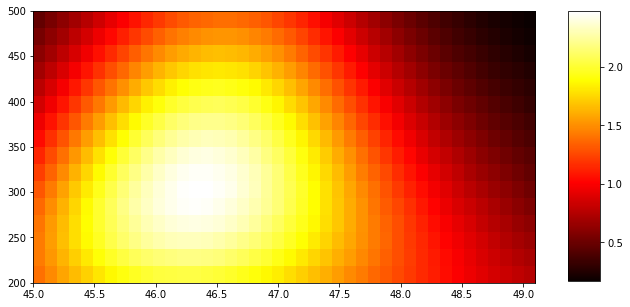

Gap_max:  300 Angle_max:  46.3


In [232]:
get_I_alpha_d()

##### 10 мкм с перефокусом 100 мкм

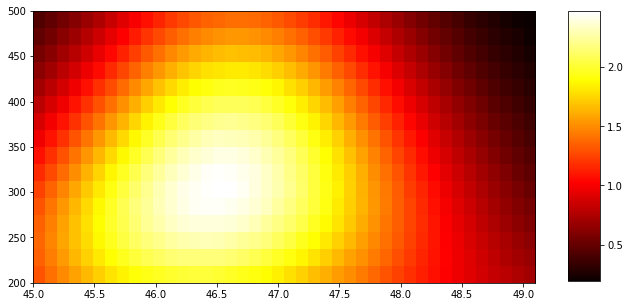

Gap_max:  300 Angle_max:  46.5


In [236]:
get_I_alpha_d()

##### 10 мкм с недофокусом 100 мкм 

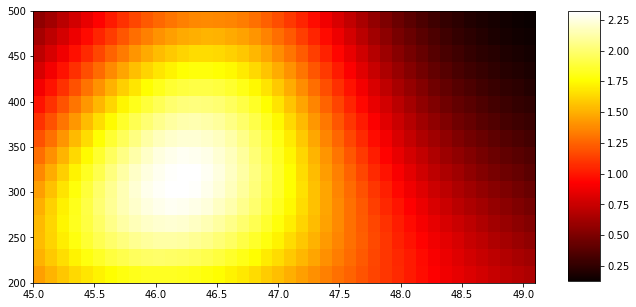

Gap_max:  300 Angle_max:  46.2


In [239]:
get_I_alpha_d()

##### w = 12 мкм

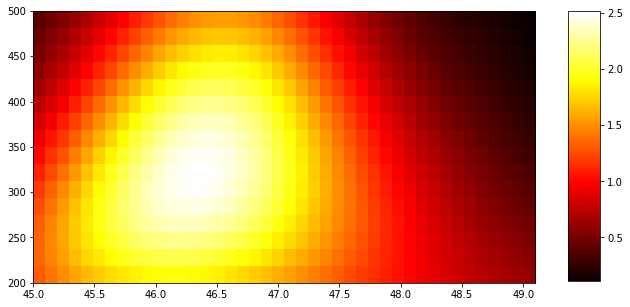

Gap_max:  320 Angle_max:  46.3


In [234]:
get_I_alpha_d()

0 / 50
1 / 50
2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50


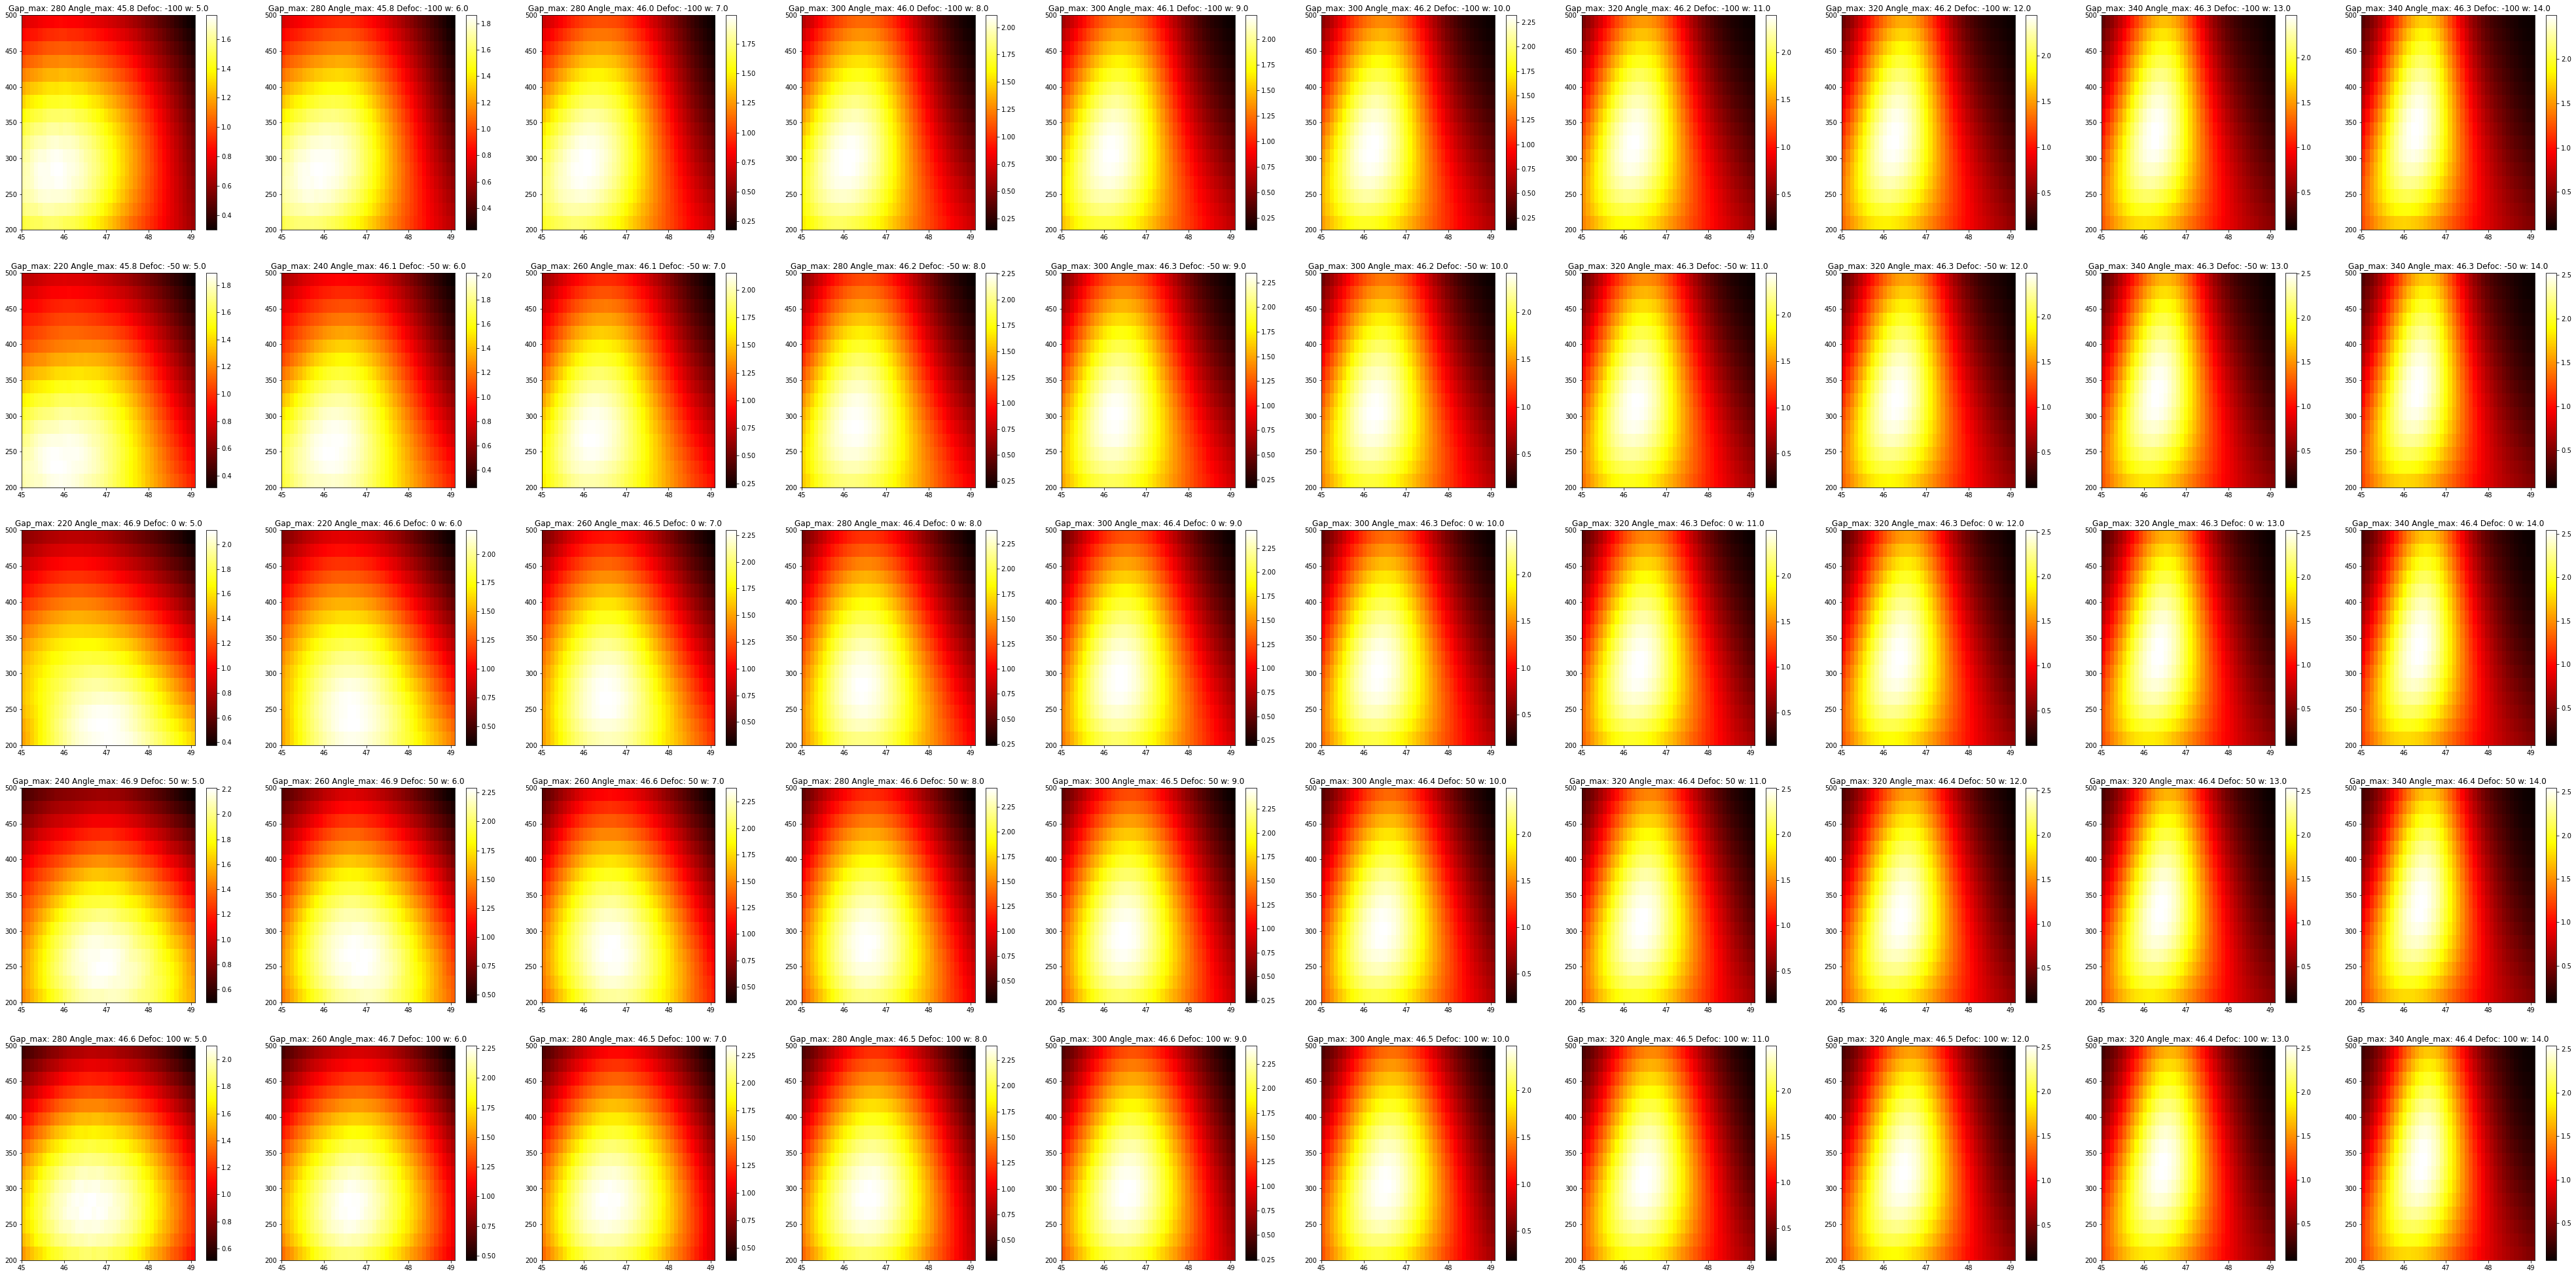

In [382]:
didic = {
    0: {
        'name': 'Среда',
        'n': 1.5 + 0.j
    },
    1: {
        'name': 'Слой',
        'n': 1 + 0.j,
        'd': 300
    },  
    2: {
        'name': 'ФК',
        'n1': 1.45 + 0.00002j,
        'd1': 204.,
        'n2': 2.07+0.00002j,
        'd2': 143.,
        'N' : 10
    },
    3: {
        'name': 'Среда',
        'n': 1.52 + 0.j
    }
}

angles_range = np.arange(45, 49.1, 0.1)
X_range = np.arange(-10, 30, 1)
gap_range = np.arange(200, 520, 20)
spots_range = np.arange(2.5, 7.5, 0.5)
defocus_range = np.arange(-100, 150, 50)
extent_h=[angles_range.min(), angles_range.max(), gap_range.min(), gap_range.max()]
fig, axs = plt.subplots(np.size(defocus_range), np.size(spots_range), figsize=(7 * np.size(spots_range), 7 * np.size(defocus_range)))

for j, defoc in enumerate(defocus_range):
    for i, spt in enumerate(spots_range):
        data = I_x_a_d(angles_range, gap_range, didic, X_range, spt, defoc)
        graph, label = get_I_alpha_d(data, angles_range, gap_range)
        label = label + " Defoc: " + str(defoc) + " w: " + str(2 * spt)
        tmp = axs[j, i].imshow(graph, cmap=plt.cm.hot, origin='lower', aspect='auto', extent=extent_h)    
        axs[j, i].set_title(label)
        plt.colorbar(tmp, ax=axs[j, i])
        print(j * np.size(spots_range) + i, "/", np.size(defocus_range) * np.size(spots_range))
fig.savefig("/home/kwillum/E_dist.png")

## Спектры E_f,b в воздушном зазоре:

In [351]:
def decor(angles, wl, didic):
    return R_func(didic, wl, angles)
vectorize_R = np.vectorize(decor)

def get_air_E_fb(struct, k_x, a=5, alpha=45, gap=0.3, L=0):
    '''
    set default parameters range
    '''
    wl = 780.

    '''
    get comon variables
    '''
    k = 2 * np.pi * 1000000000 / wl * struct[0]['n'].real
    k_mkm = k / 1000000.
    k_mkm_gap = k_mkm / struct[0]['n'].real * struct[1]['n'].real
    s = S_k(a, k_x).reshape((-1, 1))

    angles = 180 / np.pi * np.arcsin(k_x / k_mkm) + alpha
    R = vectorize_R(angles, wl, struct).reshape((-1, 1))
    TMMs = generate_TMM(struct, angles)
    k_xz = get_K_xz_air(k_mkm, k_mkm_gap, angles)
    defocus_phase = get_defocus_phase(k_mkm, angles, L)
    E_plus, E_minus = E_air_spectrum(s, R, TMMs)
    E_plus = E_plus * defocus_phase
    E_minus = E_minus * defocus_phase
    return E_plus, E_minus, angles

In [352]:
def get_descr(x, y):
    return "min: " + str(x[np.argmin(y)])[:5] + " max: " + str(x[np.argmax(y)])[:5]

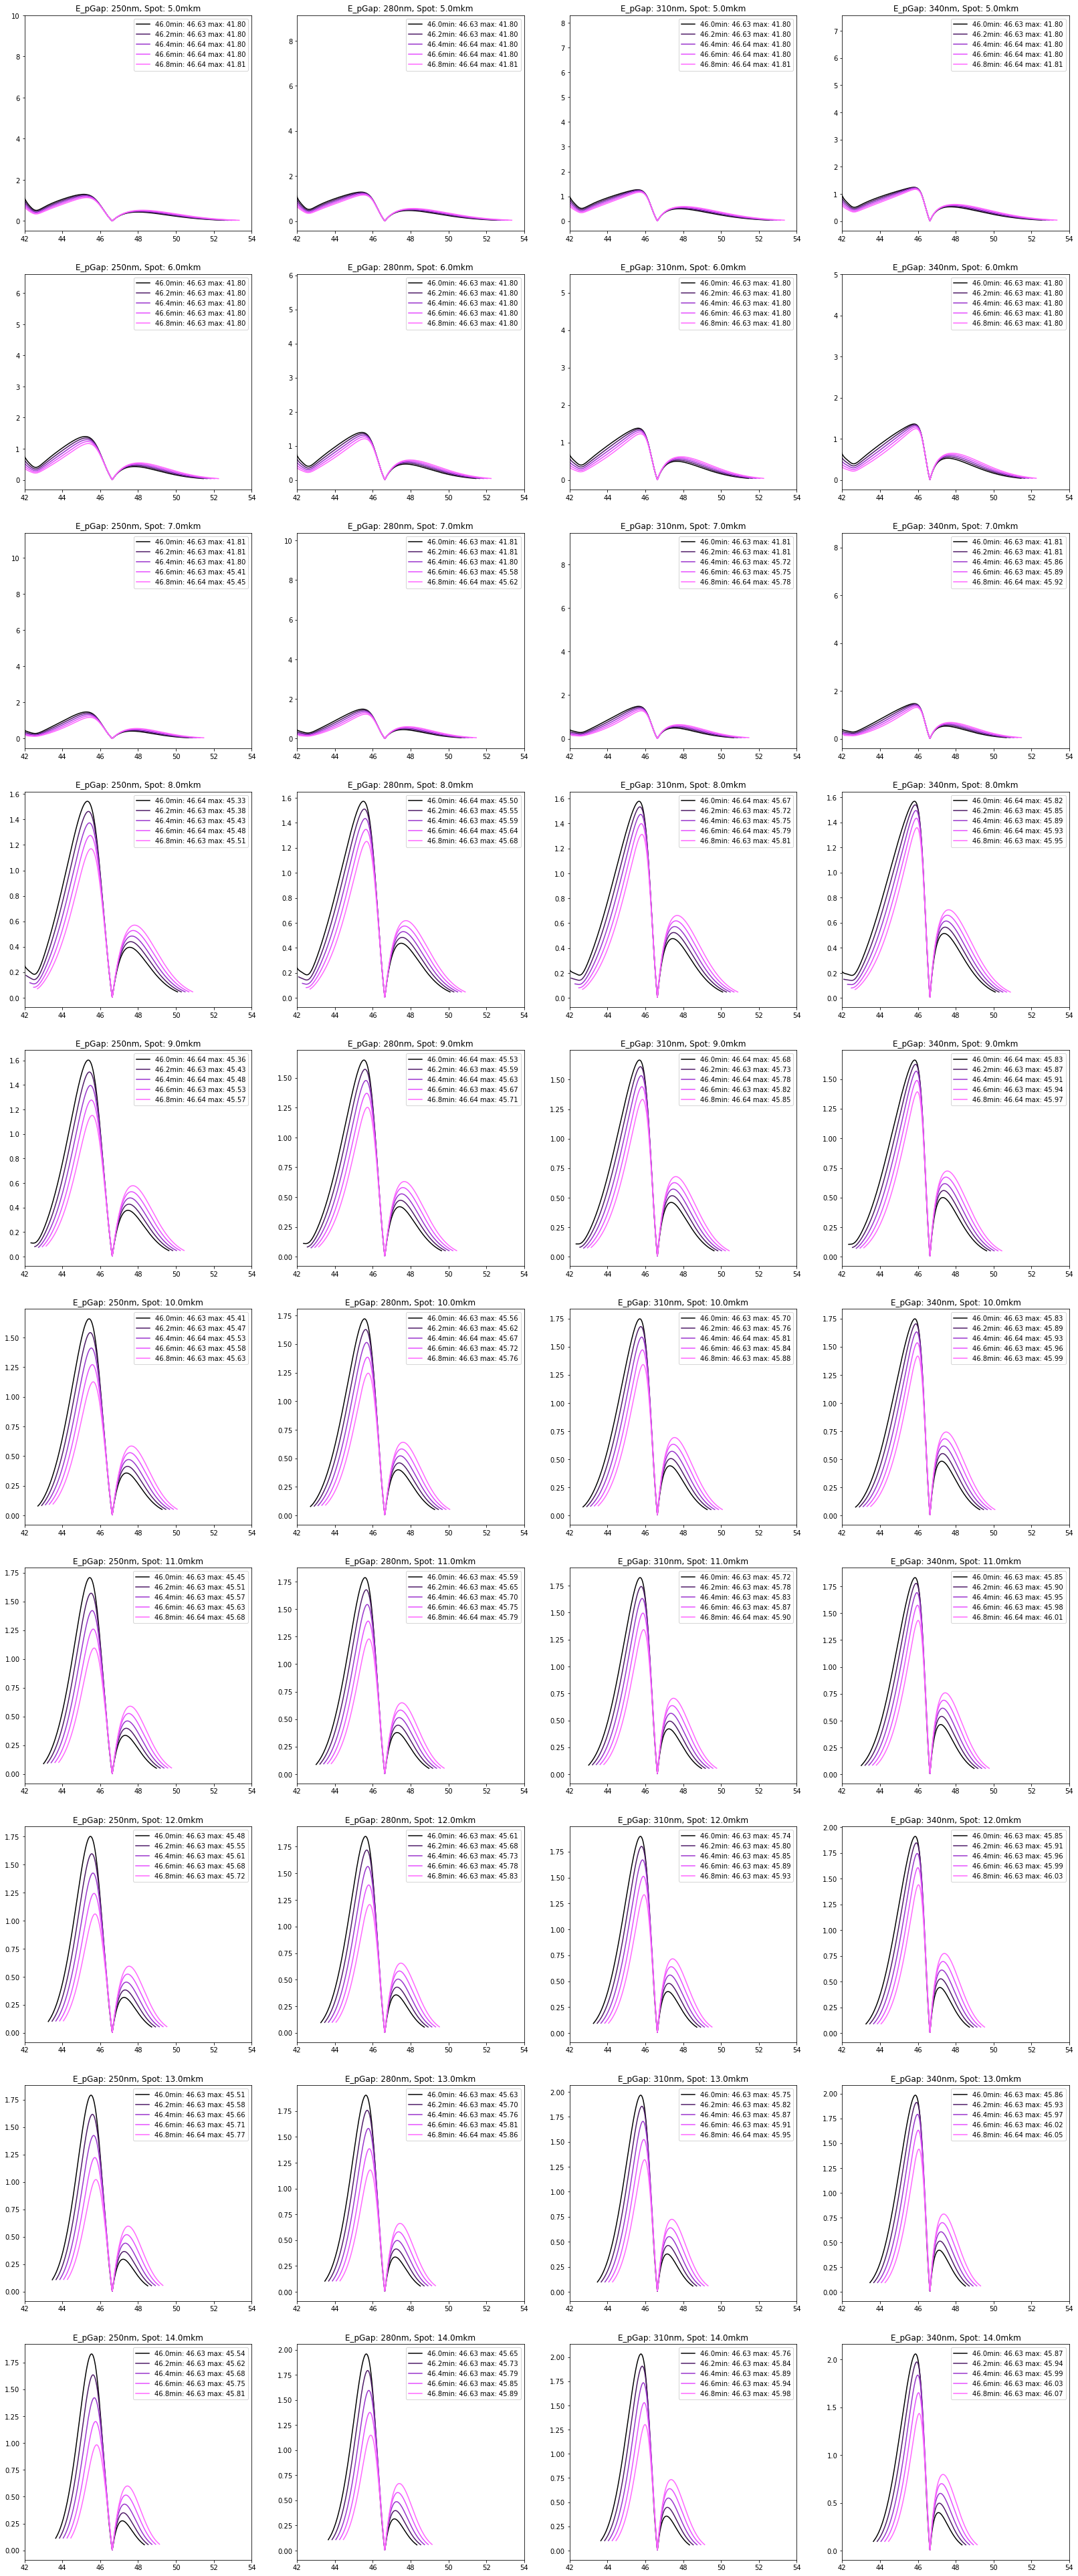

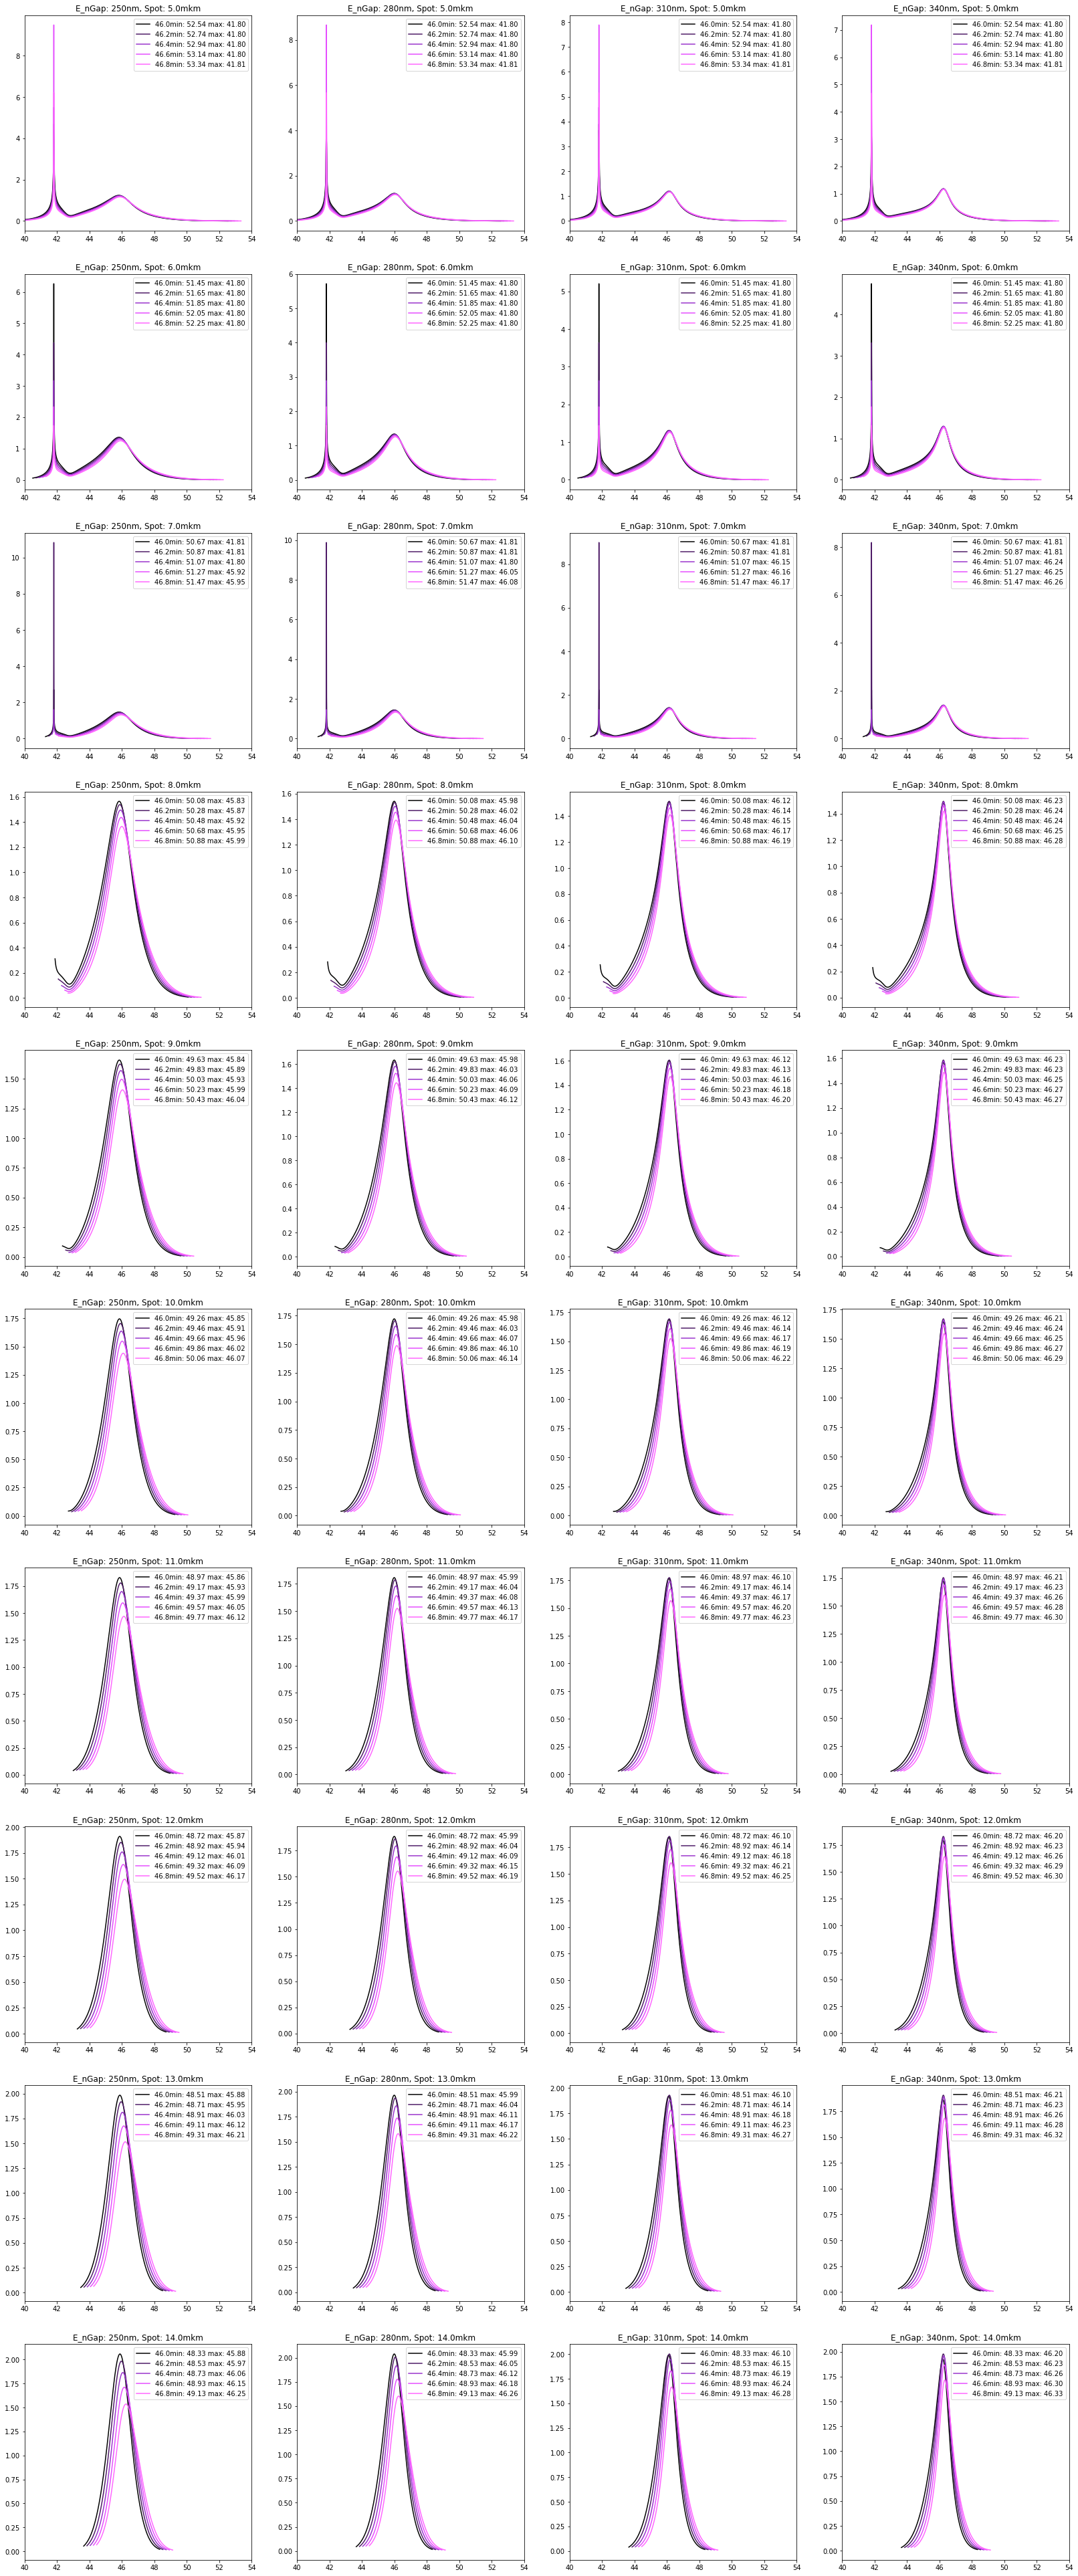

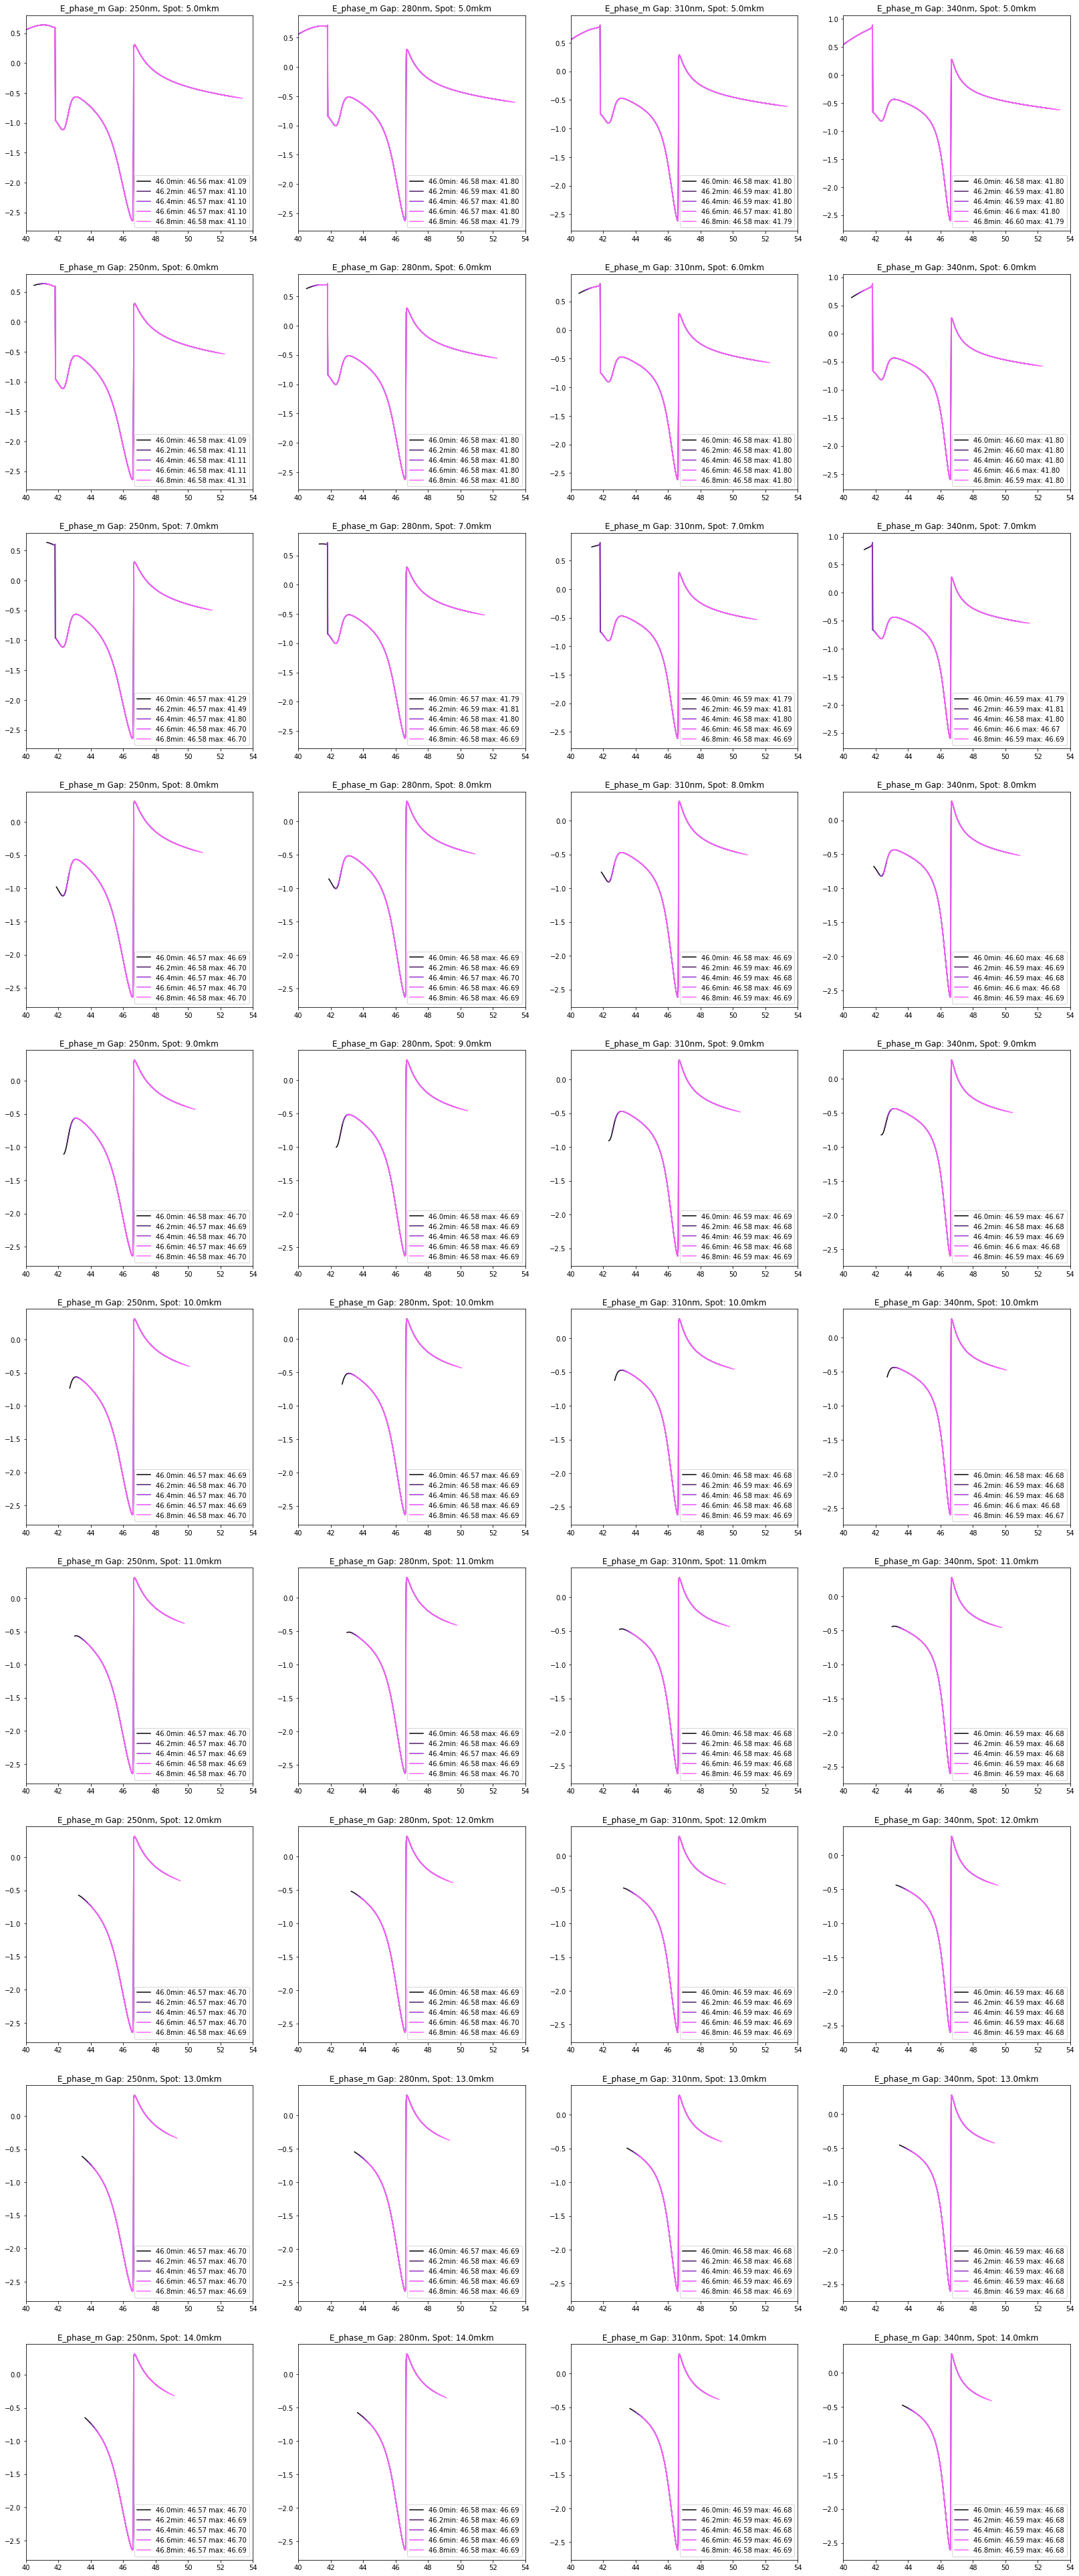

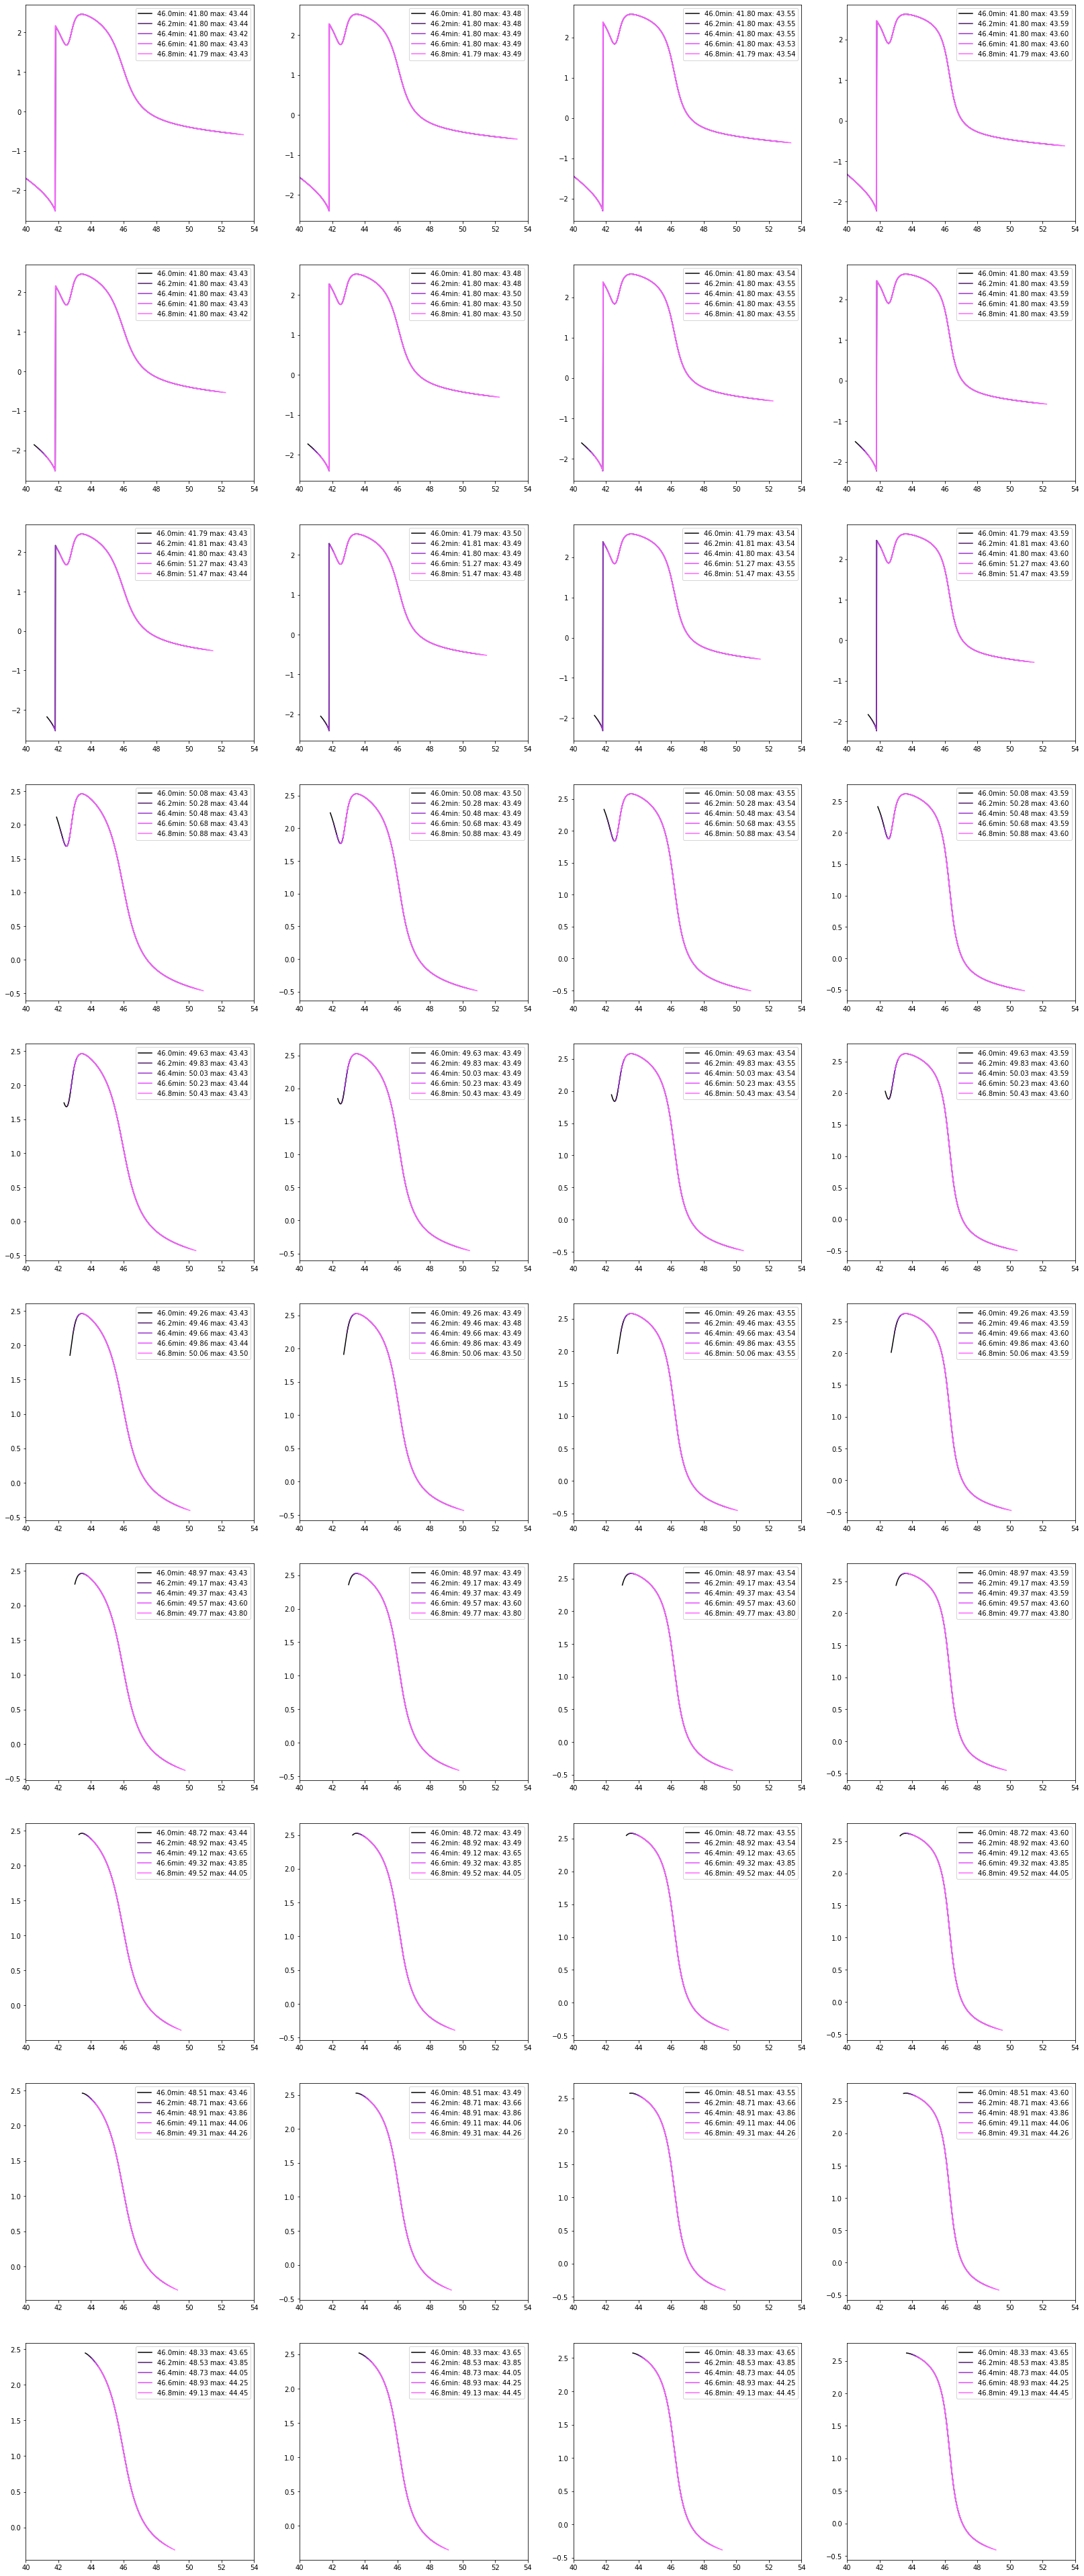

In [360]:
didic = {
    0: {
        'name': 'Среда',
        'n': 1.5 + 0.j
    },
    1: {
        'name': 'Слой',
        'n': 1 + 0.j,
        'd': 300
    },  
    2: {
        'name': 'ФК',
        'n1': 1.45 + 0.00002j,
        'd1': 204.,
        'n2': 2.07+0.00002j,
        'd2': 143.,
        'N' : 10
    },
    3: {
        'name': 'Среда',
        'n': 1.52 + 0.j
    }
}

thetas = np.arange(46, 47, 0.2)
air_gaps = np.arange(250, 350, 30)
spots = np.arange(2.5, 7.5, 0.5)
fig, axs = plt.subplots(np.size(spots), np.size(air_gaps), figsize=(7 * np.size(air_gaps), 7 * np.size(spots)))
fig1, axs1 = plt.subplots(np.size(spots), np.size(air_gaps), figsize=(7 * np.size(air_gaps), 7 * np.size(spots)))
fig2, axs2 = plt.subplots(np.size(spots), np.size(air_gaps), figsize=(7 * np.size(air_gaps), 7 * np.size(spots)))
fig3, axs3 = plt.subplots(np.size(spots), np.size(air_gaps), figsize=(7 * np.size(air_gaps), 7 * np.size(spots)))


for v, a in enumerate(spots):
    k_x = get_k_x(a=a, N_x=601, decr_times=20)
    for i, ag in enumerate(air_gaps):
        didic[1]['d'] = ag
        for j, th in enumerate(thetas):
            axs1[v, i].set_xlim([40, 54])
            axs2[v, i].set_xlim([40, 54])
            axs3[v, i].set_xlim([40, 54])
            axs[v, i].set_xlim([42, 54])
            E_p, E_m, a_x = get_air_E_fb(didic, k_x, a, th, didic[1]['d'])
            axs[v, i].plot(a_x, abs(E_p), c=[np.min([0.3 * j, 1]), 0.1 * j, np.min([0.4 * j, 1])],
                           label=str(th) + get_descr(a_x, abs(E_p)))
            axs1[v, i].plot(a_x, abs(E_m), c=[np.min([0.3 * j, 1]), 0.1 * j, np.min([0.4 * j, 1])],
                            label=str(th) + get_descr(a_x, abs(E_m)))
            
            axs2[v, i].plot(a_x, np.angle(E_p), c=[np.min([0.3 * j, 1]), 0.1 * j, np.min([0.4 * j, 1])],
                              label=str(th) + get_descr(a_x, np.angle(E_p)))
            axs3[v, i].plot(a_x, np.angle(E_m), c=[np.min([0.3 * j, 1]), 0.1 * j, np.min([0.4 * j, 1])],
                              label=str(th) + get_descr(a_x, np.angle(E_m)))
            
            make_title = "Gap: " + str(ag) + "nm, Spot: " + str(2 * a) + "mkm"
            axs[v, i].set_title("E_p" + make_title)
            axs1[v, i].set_title("E_n" + make_title)
            axs2[v, i].set_title("E_phase_p " + make_title)
            axs2[v, i].set_title("E_phase_m " + make_title)

            axs[v, i].legend()
            axs1[v, i].legend()
            axs2[v, i].legend()
            axs3[v, i].legend()

fig.savefig("/home/kwillum/E_plus_gap_spot.png")
fig1.savefig("/home/kwillum/E_minus_gap_spot.png")
fig2.savefig("/home/kwillum/E_phase_p_gap_spot.png")
fig3.savefig("/home/kwillum/E_phase_m_gap_spot.png")

#плюс  значит, что движется от призмы к фк

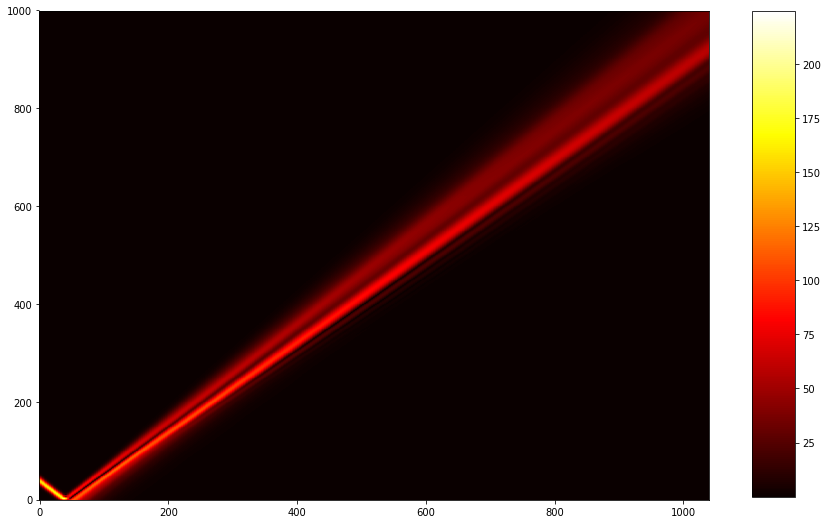

In [173]:
plt.figure(figsize=(12, 9))
plt.imshow(abs(E), cmap=plt.cm.hot, origin='lower', aspect='auto')    
#plt.xlim(46.6, 46.9)
cax = plt.axes([0.95, 0.13, 0.05, 0.75])
plt.colorbar(cax=cax)
plt.show()

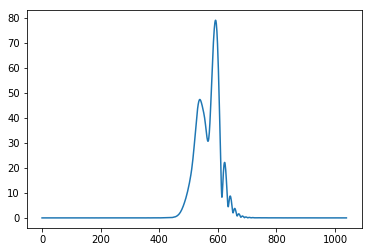

In [183]:
plt.plot(abs(E[500]))


In [176]:
fram = pd.DataFrame(data=abs(E))
fram.to_csv(r'c:\data\Gauss_5mcm_45.9_1040x1000.txt', header=None, index=None)

In [204]:
data = pd.read_csv("c:\data\Gauss_10mcm_45.9_1040x1000.txt", header=None)
plt.figure(figsize=(12, 9))
plt.imshow(data, cmap=plt.cm.hot, origin='lower', aspect='auto')    
#plt.xlim(46.6, 46.9)
cax = plt.axes([0.95, 0.13, 0.05, 0.75])
plt.colorbar(cax=cax)
plt.show()

In [51]:
from tmm import examples as ex

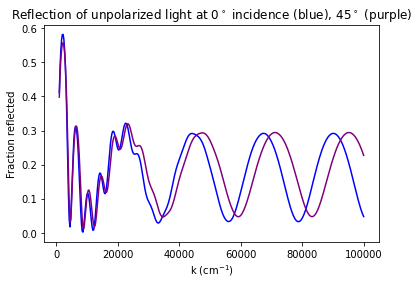

In [52]:
ex.sample1()

In [54]:
import tmm as tmm

In [65]:
%%time
didic = {
    0: {
        'name': 'Среда',
        'n': 1.5 + 0.j
    },
    1: {
        'name': 'Слой',
        'n': 1 + 0.j,
        'd': 300
    },  
    2: {
        'name': 'ФК',
        'n1': 1.45 + 0.00002j,
        'd1': 204.,
        'n2': 2.07+0.00002j,
        'd2': 143.,
        'N' : 10
    },
    3: {
        'name': 'Среда',
        'n': 1.52 + 0.j
    }
}
n_list = [1.5, 1]
for i in range(10):
    n_list.append(1.45+0.00002j)
    n_list.append(2.07+0.00002j)
n_list.append(1.52)
d_list = [np.inf, 300e-9]
for i in range(10):
    d_list.append(204e-9)
    d_list.append(143e-9)
d_list.append(np.inf)
d_list = np.array(d_list)
n_list = np.array(n_list)
print(n_list, '\n', d_list, '\n')
res = tmm.tmm_core.coh_tmm("s", n_list, d_list, np.pi / 180 * 46, 780e-9)

[ 1.50 +0.00000000e+00j  1.00 +0.00000000e+00j  1.45 +2.00000000e-05j
  2.07 +2.00000000e-05j  1.45 +2.00000000e-05j  2.07 +2.00000000e-05j
  1.45 +2.00000000e-05j  2.07 +2.00000000e-05j  1.45 +2.00000000e-05j
  2.07 +2.00000000e-05j  1.45 +2.00000000e-05j  2.07 +2.00000000e-05j
  1.45 +2.00000000e-05j  2.07 +2.00000000e-05j  1.45 +2.00000000e-05j
  2.07 +2.00000000e-05j  1.45 +2.00000000e-05j  2.07 +2.00000000e-05j
  1.45 +2.00000000e-05j  2.07 +2.00000000e-05j  1.45 +2.00000000e-05j
  2.07 +2.00000000e-05j  1.52 +0.00000000e+00j] 
 [             inf   3.00000000e-07   2.04000000e-07   1.43000000e-07
   2.04000000e-07   1.43000000e-07   2.04000000e-07   1.43000000e-07
   2.04000000e-07   1.43000000e-07   2.04000000e-07   1.43000000e-07
   2.04000000e-07   1.43000000e-07   2.04000000e-07   1.43000000e-07
   2.04000000e-07   1.43000000e-07   2.04000000e-07   1.43000000e-07
   2.04000000e-07   1.43000000e-07              inf] 

CPU times: user 885 µs, sys: 3.98 ms, total: 4.86 ms
Wall ti

In [79]:
angles = np.linspace(45, 50, 100000)
R_res = np.empty(np.shape(angles), dtype=np.complex)
for ctr, al in enumerate(angles):
    R_res[ctr]=tmm.tmm_core.coh_tmm("s", n_list, d_list, np.pi / 180 * al, 780e-9)['r']

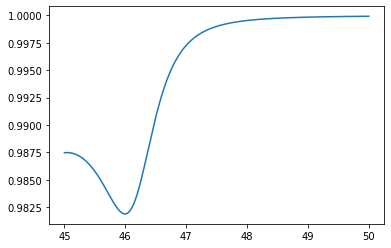

In [80]:
plt.plot(angles, abs(R_res))